# Challenge: Factors that affect life expectancy


Throughout this module, we dove deep into the topics of exploratory data analysis (EDA) and its substeps. Now it's time to apply your knowledge. In this challenge, you'll work with the [Life Expectancy dataset](https://www.kaggle.com/kumarajarshi/life-expectancy-who) from Kaggle. The data is collected from the websites of the World Health Organisation (WHO) and World Bank (WB). The dataset contains annual variables for many of the countries in the world which are divided into several broad categories: immunization related factors, mortality factors, economical factors, and social factors.

You should access the data from the Thinkful database. Here's the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'lifeexpectancy'<br>
table_name = 'lifeexpectancy'<br>

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks. Moreover, you can also submit a kernel to the Kaggle containing your solutions.

* Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

* First, load the dataset.

* Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them. 

* Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

* In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

* Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

In [1]:
# Import SQL Alchemy engine
from sqlalchemy import create_engine

# Import dataframe/number packages
import pandas as pd
import numpy as np


# Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# Import stat packages
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats.stats import ttest_ind
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import boxcox

# PCA packages
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from matplotlib.colors import Normalize
from numpy.random import rand
from matplotlib import gridspec

# Shutup Warnings!
import warnings
warnings.filterwarnings('ignore')

###  First, load the dataset.

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df_life_expectancy = pd.read_sql_query('select * from lifeexpectancy',con=engine)
engine.dispose()

## Data Exploration

Let's learn some of the high-level nature of the data set

In [4]:
# number of rows, columns
df_life_expectancy.shape

(2938, 22)

In [5]:
# Find all info - rows, dtype, non-null value counts per column
df_life_expectancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [6]:
# random sampling of all columns and 5 rows of data
pd.set_option('display.max_columns', 999)
df_life_expectancy.sample(5)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2230,Sao Tome and Principe,2003,Developing,63.4,225.0,0,6.54,86.427441,43.0,0,22.2,0,94.0,11.12,94.0,1.6,649.342153,148372.0,7.4,7.4,0.504,9.7
2056,Portugal,2015,Developed,81.1,76.0,0,NaN,0.000000,98.0,8,61.6,0,98.0,NaN,98.0,0.1,1922.681000,135876.0,0.7,0.5,0.841,16.6
443,Côte d'Ivoire,2005,Developing,48.7,466.0,63,3.11,0.000000,76.0,115,22.1,90,87.0,5.39,76.0,6.1,NaN,NaN,7.2,7.1,NaN,NaN
2668,Tunisia,2012,Developing,74.9,13.0,3,1.30,585.877676,97.0,48,58.3,3,97.0,7.18,97.0,0.1,4137.554210,1886668.0,6.4,6.3,0.717,14.6
1344,Jordan,2002,Developing,72.1,129.0,4,0.54,259.157238,95.0,19,55.5,4,95.0,9.68,95.0,0.1,1812.288374,5287488.0,3.9,3.9,0.712,13.0


In [7]:
# look at all stats for all dtypes
df_life_expectancy.describe(include = 'all')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938,2938.000000,2938,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
unique,193,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Malta,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,2426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.518720,NaN,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,NaN,4.613841,NaN,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,NaN,2000.000000,NaN,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,NaN,2004.000000,NaN,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,NaN,2008.000000,NaN,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,NaN,2012.000000,NaN,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000


In [8]:
# determine which columns are likely categorical vs continuous variables
# look at the lower numbers to recognize potential categorical variables
df_life_expectancy.nunique().sort_values()

Status                                2
Year                                 16
Polio                                73
Diphtheria                           81
Hepatitis B                          87
Schooling                           173
Country                             193
 HIV/AIDS                           200
 thinness  1-19 years               200
 thinness 5-9 years                 207
infant deaths                       209
under-five deaths                   252
Life expectancy                     362
Adult Mortality                     425
 BMI                                608
Income composition of resources     625
Total expenditure                   818
Measles                             958
Alcohol                            1076
Population                         2278
percentage expenditure             2328
GDP                                2490
dtype: int64

Just from the little bit, we learned there are definitely nulls, some of the data is categorical, and the column names are labeled inconsistently. Let's move on to clean up the labels, nulls, and outliers.

## Data Cleanup

In this section I will identify and correct the nulls and outliers. <br> In addition, there may be some need to determine the validity of the data in the dataframe and some basic formating.

In [9]:
# new dataframe to avoid changing original dataset
df_life_expectancy_2 = df_life_expectancy.copy()

Need to clean up column names and possibly clean up row values.

In [10]:
# general clean up script that was used in previous exercise. Normalizes column names and removes special characters
spec_chars = ['__', ',', '(', ')', '/', '.', '"', '-', ' ', '  ']

# fewer required characters with for loop vs method chaining
for char in spec_chars:
    df_life_expectancy_2.columns = df_life_expectancy_2.columns.str.replace(char, ' ')

# needed to do this str.replace method separate from above because it took 2 runs of the code to work and that's not intuitive for users
df_life_expectancy_2.columns = df_life_expectancy_2.columns.str.strip().str.lower().str.replace(' ', '_')

# noticed that some of these columns are age, rates, and percentages. renaming for clarification
df_life_expectancy_2.rename(columns={'life_expectancy':'life_expectancy_age', 'adult_mortality':'adult_mortality_rate', 'hepatitis_b':'hepatitis_b_perc', 'polio':'polio_perc', 'total_expenditure':'total_expenditure_perc', 'diphtheria':'diphtheria_perc', 'thinness_1_19_years':'thinness_1_19_years_perc', 'thinness_5_9_years':'thinness_5_9_years_perc'}, inplace=True)

print(df_life_expectancy_2.columns)

Index(['country', 'year', 'status', 'life_expectancy_age',
       'adult_mortality_rate', 'infant_deaths', 'alcohol',
       'percentage_expenditure', 'hepatitis_b_perc', 'measles', 'bmi',
       'under_five_deaths', 'polio_perc', 'total_expenditure_perc',
       'diphtheria_perc', 'hiv_aids', 'gdp', 'population',
       'thinness_1_19_years_perc', 'thinness_5_9_years_perc',
       'income_composition_of_resources', 'schooling'],
      dtype='object')


It's possible the columns with the fewest unique values are categorical in nature. Let's take a look at each one to see if there are any inconsistencies. 

In [11]:
# Out of the categorical data, lets see if any of the country column has any inconsistencies. 
df_life_expectancy_2.country.value_counts()

Malta                                        16
Japan                                        16
New Zealand                                  16
Gambia                                       16
Finland                                      16
Malawi                                       16
Iraq                                         16
Samoa                                        16
Maldives                                     16
Saint Lucia                                  16
Lao People's Democratic Republic             16
Trinidad and Tobago                          16
Uzbekistan                                   16
Democratic Republic of the Congo             16
Mexico                                       16
Bahamas                                      16
The former Yugoslav republic of Macedonia    16
Guinea                                       16
Thailand                                     16
El Salvador                                  16
Solomon Islands                         

The frequency of most countries in the data set is 16. There are some countries with only 1 entry (scroll the bottom), which means these can negatively impact the model because they don't represent the bulk of the data. Let's drop them and see what happens.

In [12]:
# drops countries that are not listed 16 times
vc = df_life_expectancy_2['country'].value_counts()
u  = [i in set(vc[vc==16].index) for i in df_life_expectancy_2['country']]
df_life_expectancy_3 = df_life_expectancy_2[u]
df_life_expectancy_3.country.value_counts()

Malta                                        16
Japan                                        16
New Zealand                                  16
Gambia                                       16
Finland                                      16
Malawi                                       16
Iraq                                         16
Samoa                                        16
Maldives                                     16
Saint Lucia                                  16
Lao People's Democratic Republic             16
Trinidad and Tobago                          16
Uzbekistan                                   16
Democratic Republic of the Congo             16
Mexico                                       16
Bahamas                                      16
The former Yugoslav republic of Macedonia    16
Switzerland                                  16
Guinea                                       16
Thailand                                     16
El Salvador                             

Only countries with 16 entries remain in the dataframe.

In [13]:
# dropped 10 out of 2938 rows from this clean up effort
print("The dataframe shape is now " + str(df_life_expectancy_3.shape))
print("We dropped " + str(len(df_life_expectancy_2) - len(df_life_expectancy_3)) + " rows from the dataframe.")

The dataframe shape is now (2928, 22)
We dropped 10 rows from the dataframe.


In [14]:
# Checking for labeling errors within 'status' column
print(df_life_expectancy_3.status.value_counts())
print(df_life_expectancy_3.year.value_counts().sort_index())

Developing    2416
Developed      512
Name: status, dtype: int64
2000    183
2001    183
2002    183
2003    183
2004    183
2005    183
2006    183
2007    183
2008    183
2009    183
2010    183
2011    183
2012    183
2013    183
2014    183
2015    183
Name: year, dtype: int64


### Nulls

Now that some basic features are fixed, let's move on to identifying and eliminating nulls where reasonable.


In [16]:
# Count how many nulls there are per column
total_nulls = df_life_expectancy_3.isna().sum()
total_nulls.sort_values(inplace=True, ascending = False)

# Observe the percentage of nulls in each column
percent_nulls = df_life_expectancy_3.isna().sum()* 100 / len(df_life_expectancy_3)
percent_nulls.sort_values(inplace=True, ascending = False)

print('total nulls per column')
print(total_nulls)
print('------------------------\npercent nulls per column')
print(percent_nulls)

total nulls per column
population                         644
hepatitis_b_perc                   553
gdp                                443
total_expenditure_perc             226
alcohol                            193
schooling                          160
income_composition_of_resources    160
bmi                                 32
thinness_1_19_years_perc            32
thinness_5_9_years_perc             32
diphtheria_perc                     19
polio_perc                          19
under_five_deaths                    0
hiv_aids                             0
measles                              0
percentage_expenditure               0
infant_deaths                        0
adult_mortality_rate                 0
life_expectancy_age                  0
status                               0
year                                 0
country                              0
dtype: int64
------------------------
percent nulls per column
population                         21.994536
hepatitis_b

There seems to be some large null values. Let's take a look at some of them to see what the issues may be.

In [17]:
# I want to see all the data easily. 
pd.set_option('display.max_rows', None)

# Rounds the values instead of reading scientific notation.
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [18]:
# Some countries have missing numbers, while others (like the USA) have no entries for population at all.
df_life_expectancy_3[['population','year', 'country']]

,population,year,country
0,33736494.00,2015,Afghanistan
1,327582.00,2014,Afghanistan
2,31731688.00,2013,Afghanistan
3,3696958.00,2012,Afghanistan
4,2978599.00,2011,Afghanistan
5,2883167.00,2010,Afghanistan
6,284331.00,2009,Afghanistan
7,2729431.00,2008,Afghanistan
8,26616792.00,2007,Afghanistan
9,2589345.00,2006,Afghanistan


In [19]:
# 2015 is a year that alcohol and total_expenditure_perc are not reported for many countries. 

df_life_expectancy_3[['total_expenditure_perc', 'year', 'country']]

,total_expenditure_perc,year,country
0,8.16,2015,Afghanistan
1,8.18,2014,Afghanistan
2,8.13,2013,Afghanistan
3,8.52,2012,Afghanistan
4,7.87,2011,Afghanistan
5,9.20,2010,Afghanistan
6,9.42,2009,Afghanistan
7,8.33,2008,Afghanistan
8,6.73,2007,Afghanistan
9,7.43,2006,Afghanistan


In [20]:
# Make a list of columns with nulls. 
fill_list = ['alcohol', 'hepatitis_b_perc', 'percentage_expenditure', 'total_expenditure_perc', 'population', 'gdp', 'bmi', 'thinness_5_9_years_perc', 'thinness_1_19_years_perc', 'diphtheria_perc', 'polio_perc']

Since there are various forms of missing data, it seems prudent to use the mean method to fill nulls by using the "country" column for reference. This should allow incomplete entries for variables to be estimated by unique countries (instead of aimlessly using the entire column), and avoid arbitrarily assigning values not relevant for that country. This should also prevent countries with zero entries for a given variable from being populated with erroneous data. 

No countries will be deleted at this point, even though there will still be nulls in some variables. Without knowing what variables are important, it could negatively impact the study to delete countries that lack 100% of the data.

In [21]:
# Fill in nulls with mean values for each attribute, grouped by country.
# Takes forever to run!
countries = df_life_expectancy_3["country"].unique()

for col in fill_list:
    for country in countries:
        df_life_expectancy_3.loc[df_life_expectancy_3["country"] == country, col] = df_life_expectancy_3.loc[df_life_expectancy_3["country"] == country, col].fillna(
            df_life_expectancy_3[df_life_expectancy_3["country"] == country][col].mean())

In [22]:
# How did the previous method work?
# Count how many nulls there are per column
total_nulls = df_life_expectancy_3.isna().sum()
total_nulls.sort_values(inplace=True, ascending = False)


print('total nulls per column')
print(total_nulls)

total nulls per column
population                         640
gdp                                400
schooling                          160
income_composition_of_resources    160
hepatitis_b_perc                   144
total_expenditure_perc              32
bmi                                 32
thinness_1_19_years_perc            32
thinness_5_9_years_perc             32
alcohol                             16
diphtheria_perc                      0
hiv_aids                             0
polio_perc                           0
under_five_deaths                    0
measles                              0
percentage_expenditure               0
infant_deaths                        0
adult_mortality_rate                 0
life_expectancy_age                  0
status                               0
year                                 0
country                              0
dtype: int64


We still have many nulls left. Fun fact, all of these nulls are divisible by 16, which is the number of rows that accounts for each country. This is because the only nulls remaining are those that have complete missing data for a variable in a given country. Therefore, grouping by country and inserting the mean value was not effective for these cases. There's a couple more concepts to apply in order to remove these nulls.
Looking through the data, it's apparant a couple, small countries have nulls where no other country does. This is represented by the variables with few nulls. These will simply be deleted. 

Also, there are larger fish to fry and we don't want to randomly delete a significant portion of the dataset by simply using a broad stroke method like "fill na". An assumption can be made that suggests the controls of many of these attributes are (in part) determined by whether the country is designated as "Developed" or "Developing". Grouping each variable by "Status" and applying a mean value might be a "good-enough" approach to infill missing portions of the dataset. This was also validated in the work further down where we run ttests on "status".

The exclusion to this rule will be the "Population" variable. The reporting of available population numbers by year vary so much that it's impossible to determine what's accurate. China and India are prime examples of this issue, where their populations swing up and down dramatically. In the real world, I would have researched populations from a different source and overwritten the data here. This column will eventually be dropped.

In order to use "status" as our guideline, we must believe this column to be as accurate as possible. Using "income_composition_of_resources", let's see if there are any basic mistakes and correct this first.

In [23]:
df_life_expectancy_3.groupby(['country','status'])['income_composition_of_resources'].mean().sort_values(ascending = False)

country                                               status    
Norway                                                Developed    0.93
Australia                                             Developed    0.92
Switzerland                                           Developed    0.91
Denmark                                               Developed    0.90
Netherlands                                           Developed    0.90
Germany                                               Developed    0.89
Sweden                                                Developed    0.89
Canada                                                Developing   0.89
Ireland                                               Developed    0.89
New Zealand                                           Developed    0.89
Iceland                                               Developed    0.89
Luxembourg                                            Developed    0.88
Belgium                                               Developed    0.88

Countries like Canada and France are recorded as developing countries. This isn't correct. Referring to the UN classifications for developed countries, it's clear that there are multiple errors in the "status" column. Using the list from the UN as guidance, a bulk of errors occur at and above 0.84 in the "income_composition_of_resources" column. Let's reassign the correct status to the appropriate countries. This is a shotgun approach, but should correct enough errors for this purpose.

In [24]:
# Transform status of high income comp of resources from "developing" to "developed" status
df_life_expectancy_3.loc[df_life_expectancy_3.income_composition_of_resources >= 0.84, 'status'] = "Developed"

Next, lets go ahead and group by status and fill in the means of the missing values.
The next few rows of code are for basic cross checks.

In [25]:
df_life_expectancy_3.groupby('status')['percentage_expenditure'].mean()

status
Developed    2707.60
Developing    226.90
Name: percentage_expenditure, dtype: float64

In [26]:
df_life_expectancy_3.groupby('status')['income_composition_of_resources'].mean()

status
Developed    0.86
Developing   0.57
Name: income_composition_of_resources, dtype: float64

In [27]:
df_life_expectancy_3.groupby('status')['schooling'].mean()

status
Developed    15.87
Developing   11.02
Name: schooling, dtype: float64

In [105]:
# Finding the significance of difference of Average_Life_Expectancy between Developed and Developing countries using 
# t-test

stats.ttest_ind(df_life_expectancy_3.loc[df_life_expectancy_3['status']=='Developed','life_expectancy_age'],df_life_expectancy_3.loc[df_life_expectancy_3['status']=='Developing','life_expectancy_age'])

Ttest_indResult(statistic=35.46975719819496, pvalue=1.5287333827780653e-229)

It appears status is a statistically significant feature with reference to the target variable.

In [53]:
# list of columns with null values
null_list = ['bmi', 'thinness_5_9_years_perc', 'thinness_1_19_years_perc', 'gdp', 'total_expenditure_perc', 'alcohol', 'percentage_expenditure', 'income_composition_of_resources', 'schooling', 'hepatitis_b_perc']

In [54]:
# this script takes columns from a provided list, groups by "status", then averages the variable based on the status of that country.
# The infill of the data will be a broad average, but will hopefully be good enough based on the macro trends.
for col in null_list:
    df_life_expectancy_3[col] = df_life_expectancy_3[col].fillna(df_life_expectancy_3.groupby('status')[col].transform('mean'))

Dropping "population" for reasons listed above.

In [55]:
df_life_expectancy_4 = df_life_expectancy_3.copy()

In [56]:
df_life_expectancy_4 = df_life_expectancy_4.drop(['population'], axis = 1)

In [57]:
df_life_expectancy_4.head()

,country,year,status,life_expectancy_age,adult_mortality_rate,infant_deaths,alcohol,percentage_expenditure,hepatitis_b_perc,measles,bmi,under_five_deaths,polio_perc,total_expenditure_perc,diphtheria_perc,hiv_aids,gdp,thinness_1_19_years_perc,thinness_5_9_years_perc,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.00,263.00,62,0.01,71.28,65.00,1154,19.10,83,6.00,8.16,65.00,0.10,584.26,17.20,17.30,0.48,10.10
1,Afghanistan,2014,Developing,59.90,271.00,64,0.01,73.52,62.00,492,18.60,86,58.00,8.18,62.00,0.10,612.70,17.50,17.50,0.48,10.00
2,Afghanistan,2013,Developing,59.90,268.00,66,0.01,73.22,64.00,430,18.10,89,62.00,8.13,64.00,0.10,631.74,17.70,17.70,0.47,9.90
3,Afghanistan,2012,Developing,59.50,272.00,69,0.01,78.18,67.00,2787,17.60,93,67.00,8.52,67.00,0.10,669.96,17.90,18.00,0.46,9.80
4,Afghanistan,2011,Developing,59.20,275.00,71,0.01,7.10,68.00,3013,17.20,97,68.00,7.87,68.00,0.10,63.54,18.20,18.20,0.45,9.50


In [58]:
# Recheck nulls
# Count how many nulls there are per column
total_nulls = df_life_expectancy_4.isna().sum()
total_nulls.sort_values(inplace=True, ascending = False)

# Observe the percentage of nulls in each column
percent_nulls = df_life_expectancy_4.isna().sum()* 100 / len(df_life_expectancy_4)
percent_nulls.sort_values(inplace=True, ascending = False)

print('total nulls per column')
print(total_nulls)
print('------------------------\npercent nulls per column')
print(percent_nulls)

total nulls per column
schooling                          0
measles                            0
year                               0
status                             0
life_expectancy_age                0
adult_mortality_rate               0
infant_deaths                      0
alcohol                            0
percentage_expenditure             0
hepatitis_b_perc                   0
bmi                                0
income_composition_of_resources    0
under_five_deaths                  0
polio_perc                         0
total_expenditure_perc             0
diphtheria_perc                    0
hiv_aids                           0
gdp                                0
thinness_1_19_years_perc           0
thinness_5_9_years_perc            0
country                            0
dtype: int64
------------------------
percent nulls per column
schooling                         0.00
measles                           0.00
year                              0.00
status              

Notice some numeric data is float64 and int64. It might be simpler if all numeric columns are floats. Leaving out 'year' and 'life_expectancy_age' because they are categorical variables and might need to be treated differently.

In [59]:
# Change int64 to float64 except for 'year'
df_life_expectancy_4[['infant_deaths', 'measles', 'under_five_deaths']] = df_life_expectancy_4[['infant_deaths', 'measles', 'under_five_deaths']].astype(float)
#df_life_expectancy_4['measles'] = df_life_expectancy_4['measles'].astype(float)
df_life_expectancy_4['life_expectancy_age'] = df_life_expectancy_4['life_expectancy_age'].astype(np.int64)
df_life_expectancy_4.dtypes

country                             object
year                                 int64
status                              object
life_expectancy_age                  int64
adult_mortality_rate               float64
infant_deaths                      float64
alcohol                            float64
percentage_expenditure             float64
hepatitis_b_perc                   float64
measles                            float64
bmi                                float64
under_five_deaths                  float64
polio_perc                         float64
total_expenditure_perc             float64
diphtheria_perc                    float64
hiv_aids                           float64
gdp                                float64
thinness_1_19_years_perc           float64
thinness_5_9_years_perc            float64
income_composition_of_resources    float64
schooling                          float64
dtype: object

### Next up, removing outliers!

In [60]:
# fist, let's make a new dataframe
df_life_expectancy_5 = df_life_expectancy_4.copy()

In [61]:
# setting up a few useful lists of columns based on their unique characteristics. Dealing with the dataframe of 22 columns, 
# there's bound to be need of for loops and/or functions that handle groups of data.
numerics = ['float64', 'int64'] # all columns with numers
numeric_list = df_life_expectancy_4.select_dtypes(include = numerics).columns
num_var_list = df_life_expectancy_5.select_dtypes(include = [np.float]).columns # only columns with floats
cat_var_list = list(set(list(df_life_expectancy_5.columns)) - set(num_var_list)) # only columns that are categorical
word_var_list = df_life_expectancy_5.select_dtypes(include = 'object').columns # only columns that are objects/strings

print(num_var_list)
print(cat_var_list)
print(word_var_list)
print(numeric_list)

Index(['adult_mortality_rate', 'infant_deaths', 'alcohol',
       'percentage_expenditure', 'hepatitis_b_perc', 'measles', 'bmi',
       'under_five_deaths', 'polio_perc', 'total_expenditure_perc',
       'diphtheria_perc', 'hiv_aids', 'gdp', 'thinness_1_19_years_perc',
       'thinness_5_9_years_perc', 'income_composition_of_resources',
       'schooling'],
      dtype='object')
['life_expectancy_age', 'country', 'year', 'status']
Index(['country', 'status'], dtype='object')
Index(['year', 'life_expectancy_age', 'adult_mortality_rate', 'infant_deaths',
       'alcohol', 'percentage_expenditure', 'hepatitis_b_perc', 'measles',
       'bmi', 'under_five_deaths', 'polio_perc', 'total_expenditure_perc',
       'diphtheria_perc', 'hiv_aids', 'gdp', 'thinness_1_19_years_perc',
       'thinness_5_9_years_perc', 'income_composition_of_resources',
       'schooling'],
      dtype='object')


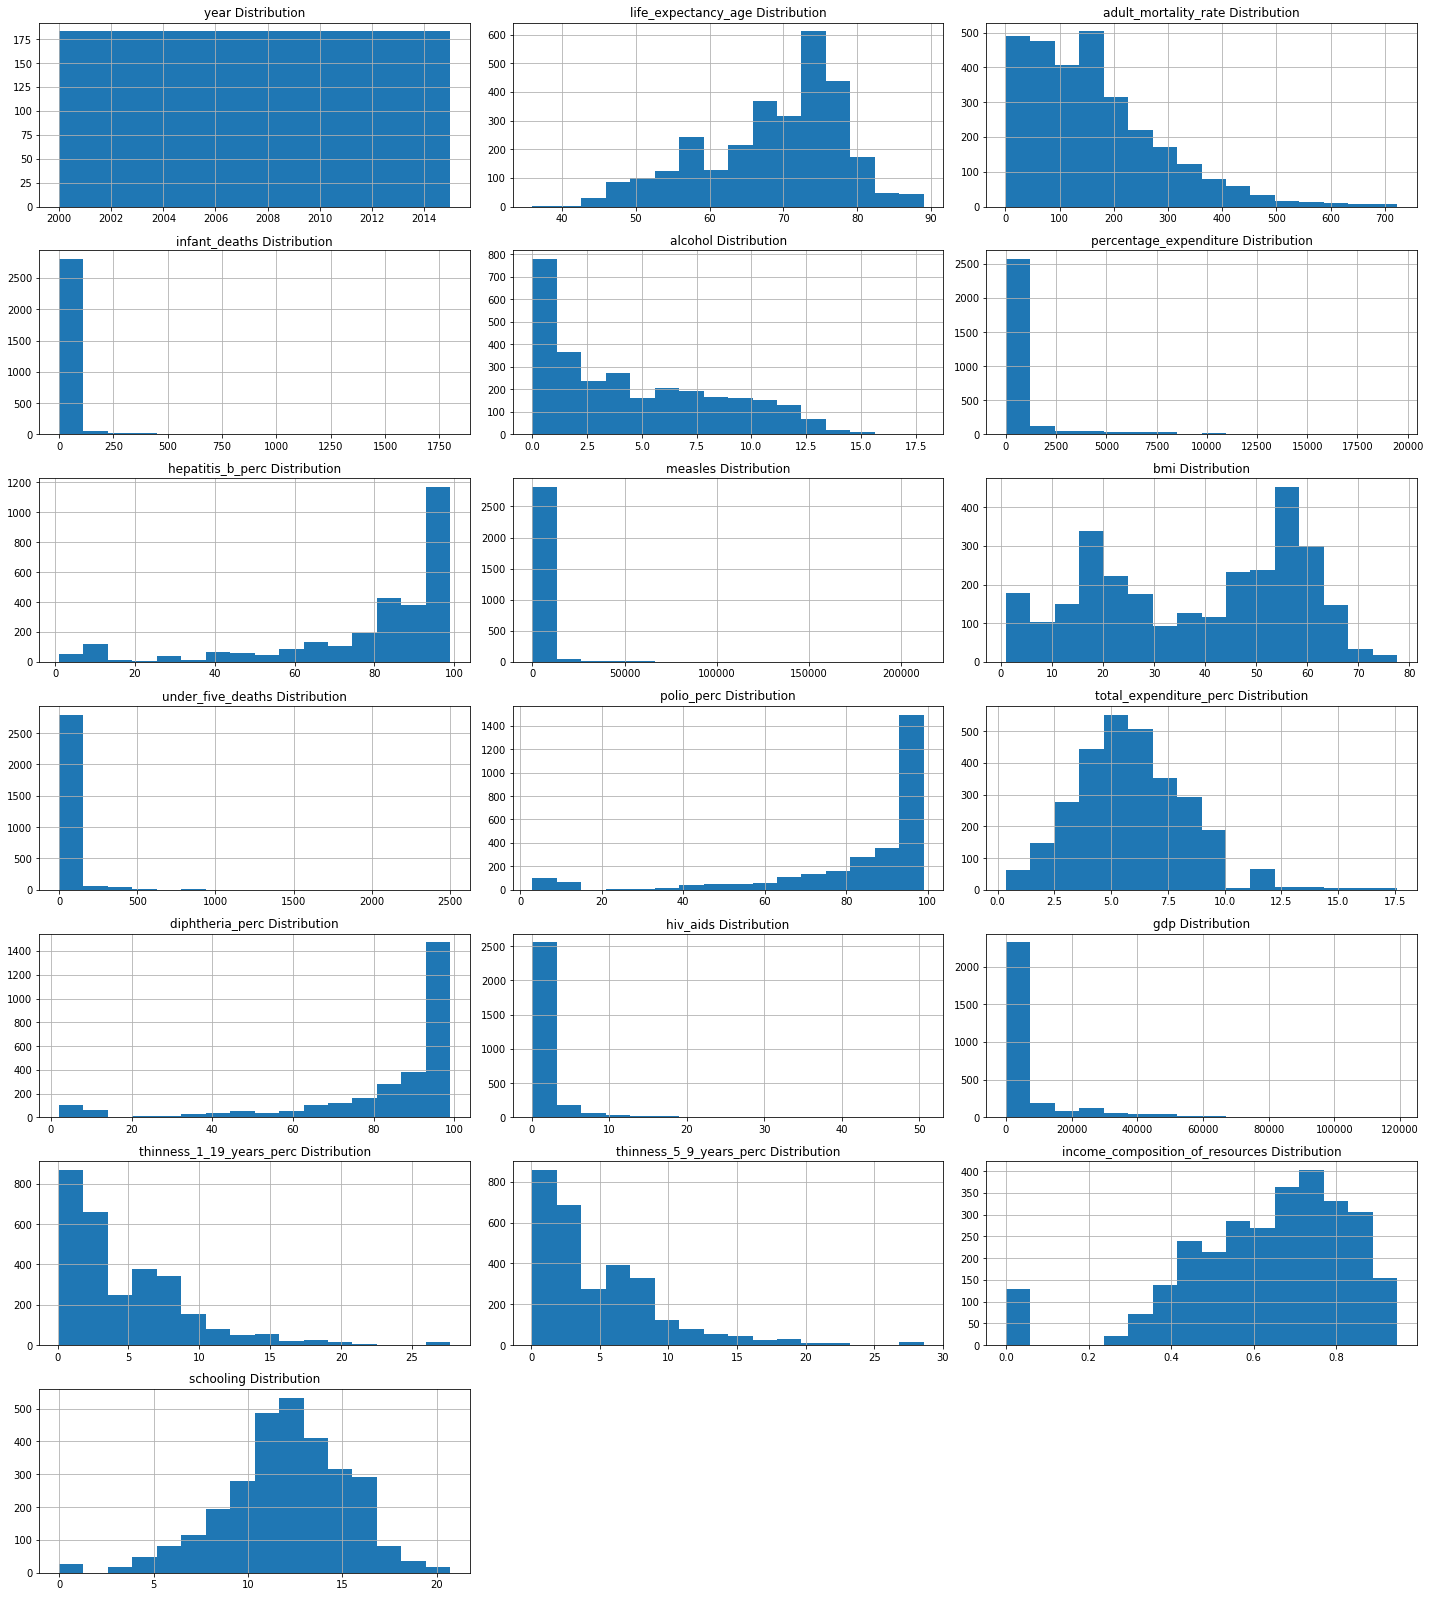

In [62]:
# Univariate visualization without having to manually plot each graph

def draw_histograms(df, columns, n_rows, n_cols):
    fig=plt.figure(figsize =(20, 60))
    for i, var_name in enumerate(columns):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=16,ax=ax)
        ax.set_title(var_name + " Distribution")
        
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()
    
draw_histograms(df_life_expectancy_5, numeric_list, len(numeric_list), 3)

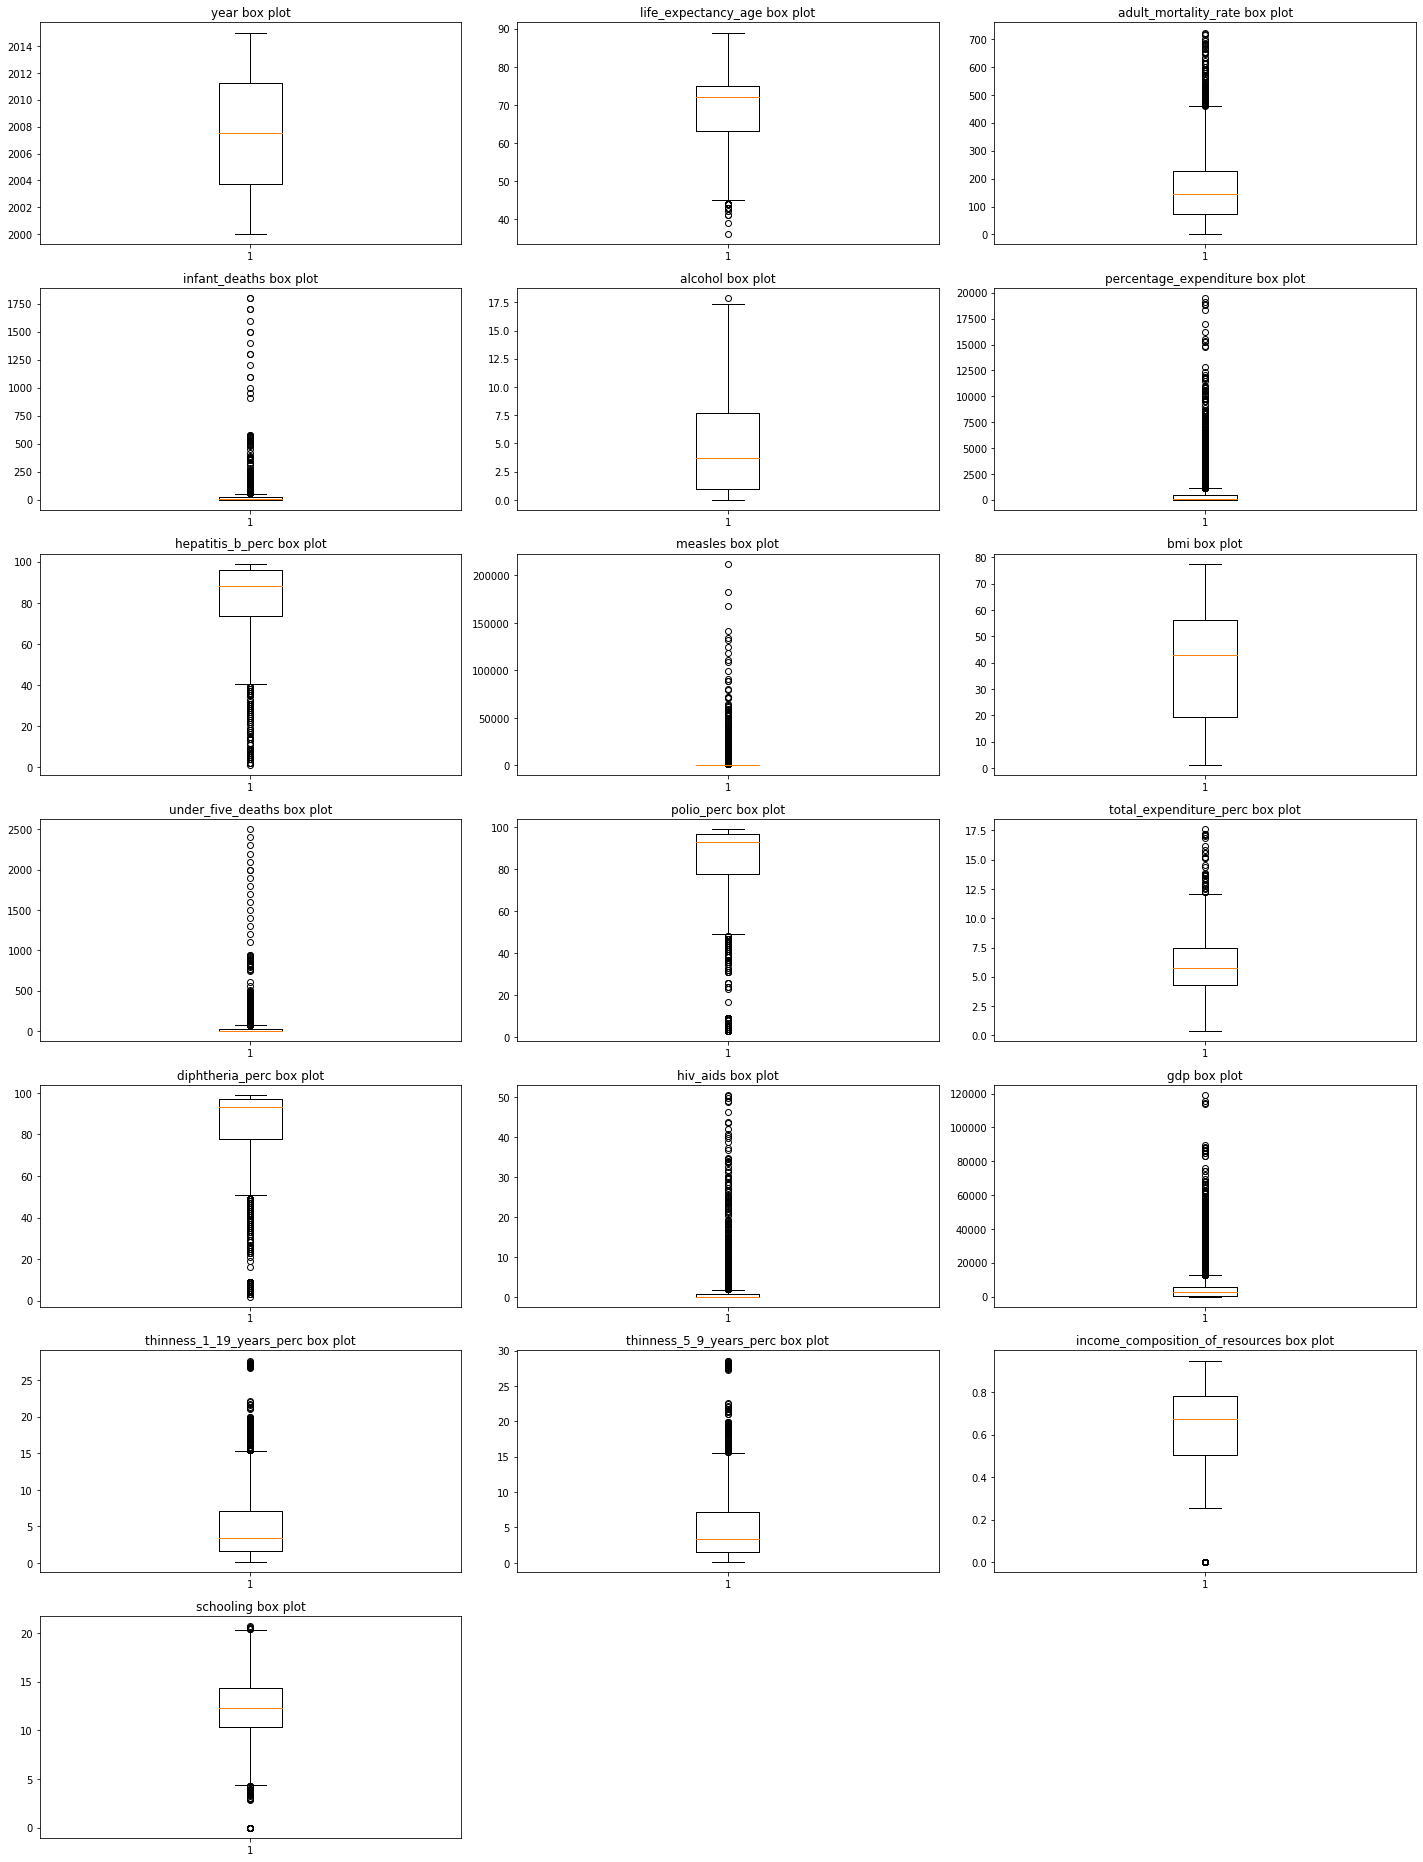

In [63]:
# box plots of to viualize outliers

def draw_box(df, columns, n_rows, n_cols):
    fig=plt.figure(figsize =(20, 70))
    for i, var_name in enumerate(columns):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        ax.boxplot(df[var_name])
        ax.set_title(var_name + ' box plot')
    fig.tight_layout()
    plt.show()
    
draw_box(df_life_expectancy_5, numeric_list, len(numeric_list), 3)

In [64]:
# Calculate number of outliers and its percentage in each variable using Tukey's method.

for variable in numeric_list:
    q75, q25 = np.percentile(df_life_expectancy_5[variable], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and {}".format(variable,
                                                                             len((np.where((df_life_expectancy_5[variable] > max_val) | 
                                                                                           (df_life_expectancy_5[variable] < min_val))[0])),len((np.where((df_life_expectancy_5[variable] > max_val) | 
                                                                                           (df_life_expectancy_5[variable] < min_val))[0]))*100/1987))

Number of outliers and percentage of it in year : 0 and 0.0
Number of outliers and percentage of it in life_expectancy_age : 19 and 0.9562154001006542
Number of outliers and percentage of it in adult_mortality_rate : 82 and 4.12682435832914
Number of outliers and percentage of it in infant_deaths : 315 and 15.853044791142425
Number of outliers and percentage of it in alcohol : 1 and 0.050327126321087066
Number of outliers and percentage of it in percentage_expenditure : 388 and 19.52692501258178
Number of outliers and percentage of it in hepatitis_b_perc : 260 and 13.085052843482638
Number of outliers and percentage of it in measles : 542 and 27.27730246602919
Number of outliers and percentage of it in bmi : 0 and 0.0
Number of outliers and percentage of it in under_five_deaths : 394 and 19.828887770508302
Number of outliers and percentage of it in polio_perc : 278 and 13.990941117262205
Number of outliers and percentage of it in total_expenditure_perc : 34 and 1.7111222949169602
Numbe

In [65]:
# create new dataframe to review zscores. This new dataframe will not be used in further analysis.
df_life_zscore = df_life_expectancy_5.copy()

In [66]:
# find zscores for all float columns, add zscore columns to existing dataframe
for col in numeric_list:
    col_zscore = col + '_zscore' # adding columns to the dataframe that result in column name + '_zscore'
    df_life_zscore[col_zscore] = (df_life_zscore[col] - df_life_zscore[col].mean())/df_life_zscore[col].std(ddof=0)
df_life_zscore.head()

,country,year,status,life_expectancy_age,adult_mortality_rate,infant_deaths,alcohol,percentage_expenditure,hepatitis_b_perc,measles,bmi,under_five_deaths,polio_perc,total_expenditure_perc,diphtheria_perc,hiv_aids,gdp,thinness_1_19_years_perc,thinness_5_9_years_perc,income_composition_of_resources,schooling,year_zscore,life_expectancy_age_zscore,adult_mortality_rate_zscore,infant_deaths_zscore,alcohol_zscore,percentage_expenditure_zscore,hepatitis_b_perc_zscore,measles_zscore,bmi_zscore,under_five_deaths_zscore,polio_perc_zscore,total_expenditure_perc_zscore,diphtheria_perc_zscore,hiv_aids_zscore,gdp_zscore,thinness_1_19_years_perc_zscore,thinness_5_9_years_perc_zscore,income_composition_of_resources_zscore,schooling_zscore
0,Afghanistan,2015,Developing,65,263.00,62.00,0.01,71.28,65.00,1154.00,19.10,83.00,6.00,8.16,65.00,0.10,584.26,17.20,17.30,0.48,10.10,1.63,-0.40,0.79,0.27,-1.14,-0.34,-0.57,-0.11,-0.96,0.25,-3.26,0.92,-0.72,-0.32,-0.50,2.81,2.77,-0.72,-0.58
1,Afghanistan,2014,Developing,59,271.00,64.00,0.01,73.52,62.00,492.00,18.60,86.00,58.00,8.18,62.00,0.10,612.70,17.50,17.50,0.48,10.00,1.41,-1.03,0.85,0.28,-1.14,-0.33,-0.69,-0.17,-0.99,0.27,-1.04,0.93,-0.85,-0.32,-0.49,2.87,2.81,-0.74,-0.61
2,Afghanistan,2013,Developing,59,268.00,66.00,0.01,73.22,64.00,430.00,18.10,89.00,62.00,8.13,64.00,0.10,631.74,17.70,17.70,0.47,9.90,1.19,-1.03,0.83,0.30,-1.14,-0.34,-0.61,-0.17,-1.01,0.29,-0.87,0.91,-0.77,-0.32,-0.49,2.92,2.86,-0.77,-0.64
3,Afghanistan,2012,Developing,59,272.00,69.00,0.01,78.18,67.00,2787.00,17.60,93.00,67.00,8.52,67.00,0.10,669.96,17.90,18.00,0.46,9.80,0.98,-1.03,0.86,0.33,-1.14,-0.33,-0.49,0.03,-1.04,0.32,-0.66,1.07,-0.64,-0.32,-0.49,2.97,2.92,-0.80,-0.68
4,Afghanistan,2011,Developing,59,275.00,71.00,0.01,7.10,68.00,3013.00,17.20,97.00,68.00,7.87,68.00,0.10,63.54,18.20,18.20,0.45,9.50,0.76,-1.03,0.89,0.34,-1.14,-0.37,-0.45,0.05,-1.06,0.34,-0.61,0.80,-0.60,-0.32,-0.53,3.03,2.97,-0.84,-0.77


In [67]:
# new dataframe with only zscores
zscore_df_filtered = df_life_zscore.filter(regex='zscore$', axis=1)
zscore_df_filtered.head()

,year_zscore,life_expectancy_age_zscore,adult_mortality_rate_zscore,infant_deaths_zscore,alcohol_zscore,percentage_expenditure_zscore,hepatitis_b_perc_zscore,measles_zscore,bmi_zscore,under_five_deaths_zscore,polio_perc_zscore,total_expenditure_perc_zscore,diphtheria_perc_zscore,hiv_aids_zscore,gdp_zscore,thinness_1_19_years_perc_zscore,thinness_5_9_years_perc_zscore,income_composition_of_resources_zscore,schooling_zscore
0,1.63,-0.40,0.79,0.27,-1.14,-0.34,-0.57,-0.11,-0.96,0.25,-3.26,0.92,-0.72,-0.32,-0.50,2.81,2.77,-0.72,-0.58
1,1.41,-1.03,0.85,0.28,-1.14,-0.33,-0.69,-0.17,-0.99,0.27,-1.04,0.93,-0.85,-0.32,-0.49,2.87,2.81,-0.74,-0.61
2,1.19,-1.03,0.83,0.30,-1.14,-0.34,-0.61,-0.17,-1.01,0.29,-0.87,0.91,-0.77,-0.32,-0.49,2.92,2.86,-0.77,-0.64
3,0.98,-1.03,0.86,0.33,-1.14,-0.33,-0.49,0.03,-1.04,0.32,-0.66,1.07,-0.64,-0.32,-0.49,2.97,2.92,-0.80,-0.68
4,0.76,-1.03,0.89,0.34,-1.14,-0.37,-0.45,0.05,-1.06,0.34,-0.61,0.80,-0.60,-0.32,-0.53,3.03,2.97,-0.84,-0.77


In [68]:
# box plots of all float data for df_life_expectancy_5
# this function with a for loop iterates throughout the dataframe by a given list to provide outlier information
# the df2 isn't 100% necessary, but it's a cleaner output for summary, and it's a good cross check based on the 2 methods to
#     make sure they both line up... Hint: they do.

def find_outliers(df, columns, df2):
    z_scores = zscore(df[columns])
    for threshold in range(1,5):
        print("The score threshold is: {}".format(threshold))
        print(z_scores[z_scores > threshold]) 
        print(((df2[df2 > threshold])).count().sort_values(ascending = False)) # provides organized sum of outliers by column
        print("The score threshold is: {}".format(threshold))
        print("The indices of the outliers:")
        print(np.where(z_scores > threshold))
        print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))
        outlier_cols = df2.columns    
    print("The outlier columns are: {}".format(outlier_cols))
         

    
find_outliers(df_life_expectancy_5, numeric_list, zscore_df_filtered)

The score threshold is: 1
[1.62697843 2.80637002 2.76650558 ... 8.2113994  1.39628274 1.40647388]
alcohol_zscore                            593
year_zscore                               549
bmi_zscore                                536
schooling_zscore                          473
total_expenditure_perc_zscore             466
income_composition_of_resources_zscore    436
adult_mortality_rate_zscore               401
life_expectancy_age_zscore                377
thinness_1_19_years_perc_zscore           354
thinness_5_9_years_perc_zscore            350
gdp_zscore                                346
percentage_expenditure_zscore             222
hiv_aids_zscore                           187
measles_zscore                            112
infant_deaths_zscore                      110
under_five_deaths_zscore                  104
diphtheria_perc_zscore                      0
polio_perc_zscore                           0
hepatitis_b_perc_zscore                     0
dtype: int64
The score thres

I originally created for loops to winsorize groups of data. However, the bulk approach was statistically inaccurate and I haven't seen any examples of how to approach this without creating unique, winsorizing code for each variable.

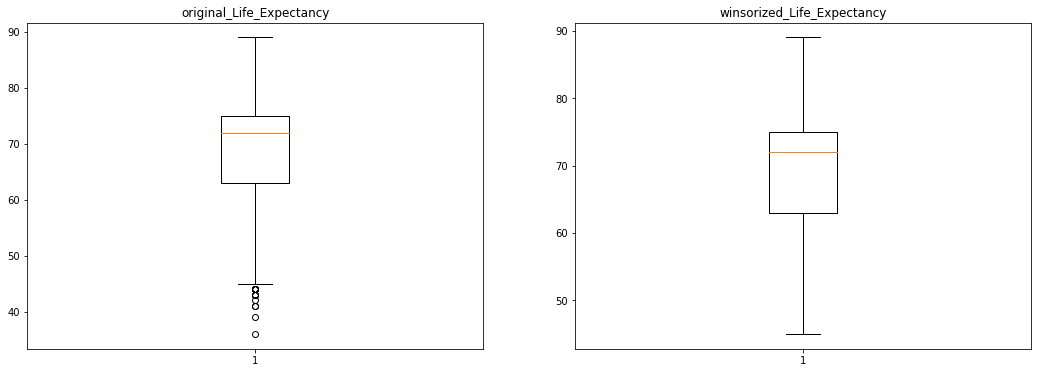

In [69]:
# Removing Outliers in the variables using Winsorization technique.
#Winsorize Life_Expectancy
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Life_Expectancy = df_life_expectancy_5['life_expectancy_age']
plt.boxplot(original_Life_Expectancy)
plt.title("original_Life_Expectancy")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_life_expectancy'] = winsorize(df_life_expectancy_5['life_expectancy_age'], (0.01, 0))
winsorized_Life_Expectancy = df_life_expectancy_5['winsorized_life_expectancy']
plt.boxplot(df_life_expectancy_5['winsorized_life_expectancy'])
plt.title("winsorized_Life_Expectancy")

plt.show()

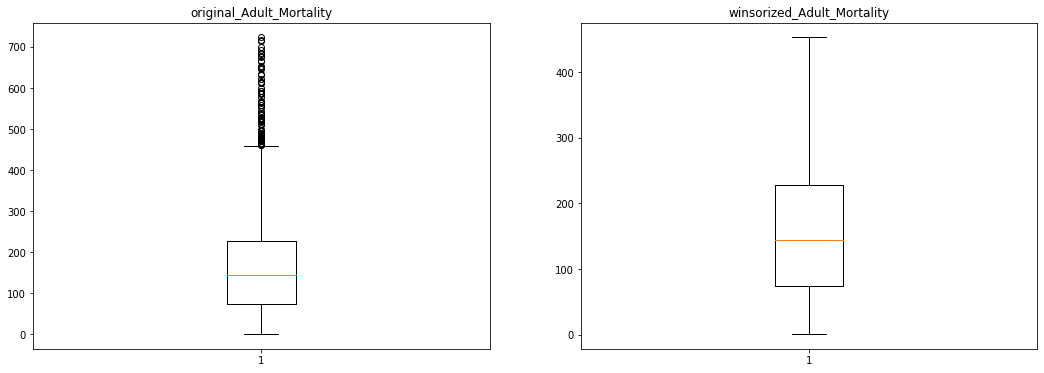

In [70]:
# Winsorize Adult_Mortality
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Adult_Mortality = df_life_expectancy_5['adult_mortality_rate']
plt.boxplot(original_Adult_Mortality)
plt.title("original_Adult_Mortality")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_adult_mortality'] = winsorize(df_life_expectancy_5['adult_mortality_rate'], (0, 0.03))
winsorized_Adult_Mortality = df_life_expectancy_5['winsorized_adult_mortality']
plt.boxplot(winsorized_Adult_Mortality)
plt.title("winsorized_Adult_Mortality")

plt.show()

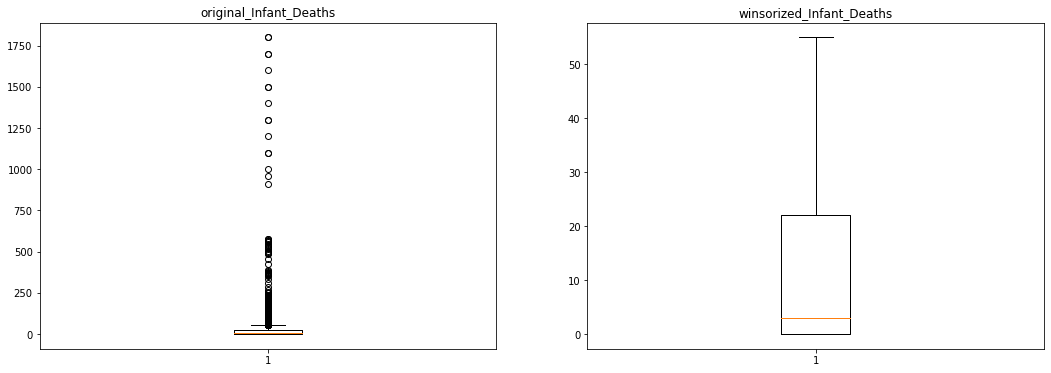

In [71]:
# Winsorize Infant_Deaths
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Infant_Deaths = df_life_expectancy_5['infant_deaths']
plt.boxplot(original_Infant_Deaths)
plt.title("original_Infant_Deaths")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_infant_deaths'] = winsorize(df_life_expectancy_5['infant_deaths'], (0, 0.11))
winsorized_Infant_Deaths = df_life_expectancy_5['winsorized_infant_deaths']
plt.boxplot(winsorized_Infant_Deaths)
plt.title("winsorized_Infant_Deaths")

plt.show()

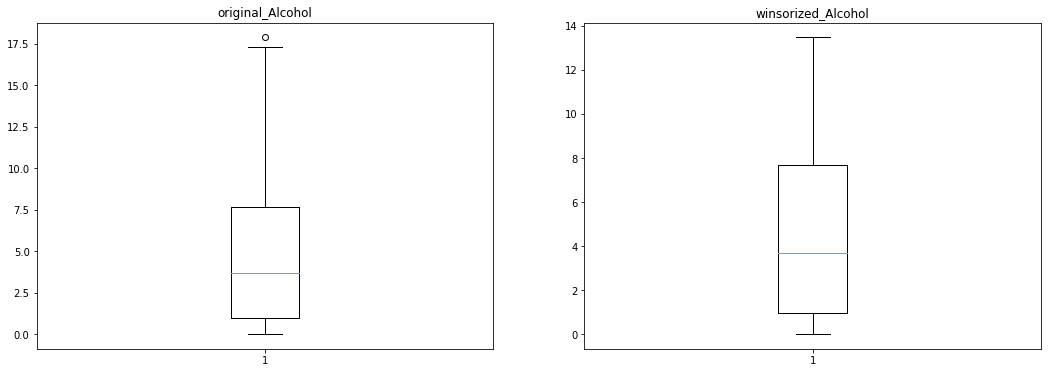

In [72]:
# Winsorize Alcohol
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Alcohol = df_life_expectancy_5['alcohol']
plt.boxplot(original_Alcohol)
plt.title("original_Alcohol")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_alcohol'] = winsorize(df_life_expectancy_5['alcohol'], (0, 0.01))
winsorized_Alcohol = df_life_expectancy_5['winsorized_alcohol']
plt.boxplot(winsorized_Alcohol)
plt.title("winsorized_Alcohol")

plt.show()

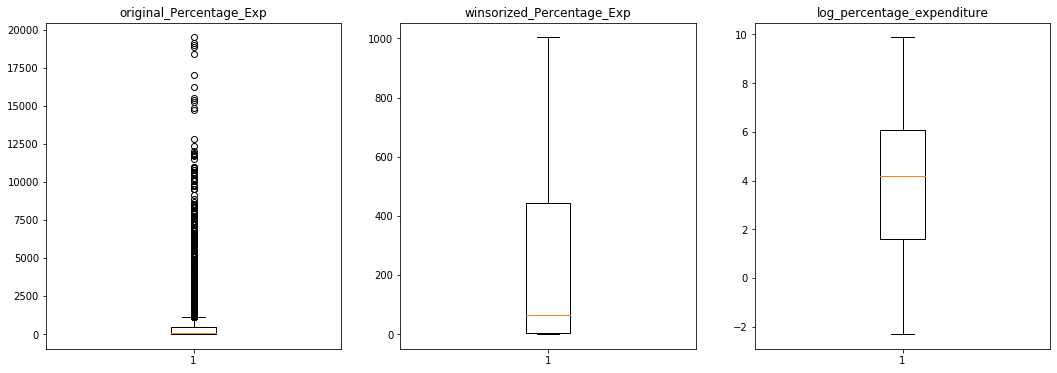

In [73]:
# Winsorize Percentage_Exp
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
original_Percentage_Exp = df_life_expectancy_5['percentage_expenditure']
plt.boxplot(original_Percentage_Exp)
plt.title("original_Percentage_Exp")

plt.subplot(1,3,2)
df_life_expectancy_5['winsorized_perc_exp'] = winsorize(df_life_expectancy_5['percentage_expenditure'], (0, 0.14))
winsorized_Percentage_Exp = df_life_expectancy_5['winsorized_perc_exp']
plt.boxplot(winsorized_Percentage_Exp)
plt.title("winsorized_Percentage_Exp")

plt.subplot(1,3,3)
df_life_expectancy_5['log_perc_exp'] = np.log(df_life_expectancy_5['percentage_expenditure'])
log_perc_exp = df_life_expectancy_5['log_perc_exp']
plt.boxplot(log_perc_exp)
plt.title("log_percentage_expenditure")


plt.show()

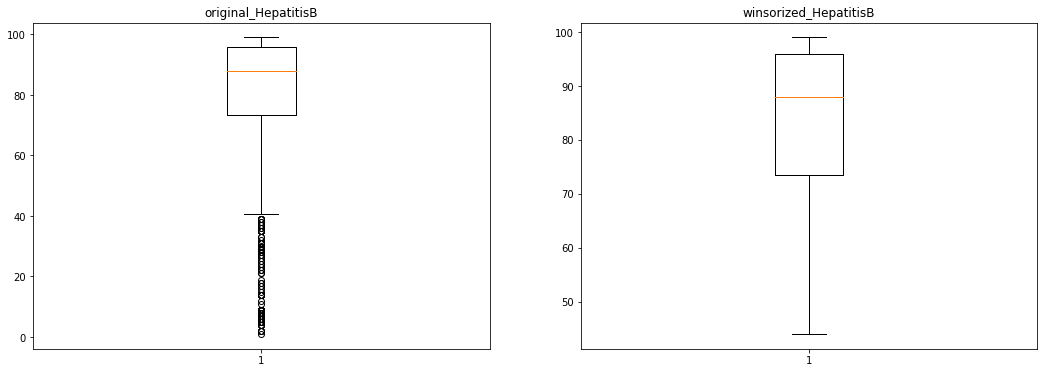

In [74]:
# Winsorize HepatitisB
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_HepatitisB = df_life_expectancy_5['hepatitis_b_perc']
plt.boxplot(original_HepatitisB)
plt.title("original_HepatitisB")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_hep_b'] = winsorize(df_life_expectancy_5['hepatitis_b_perc'], (0.11, 0))
winsorized_HepatitisB = df_life_expectancy_5['winsorized_hep_b']
plt.boxplot(winsorized_HepatitisB)
plt.title("winsorized_HepatitisB")

plt.show()

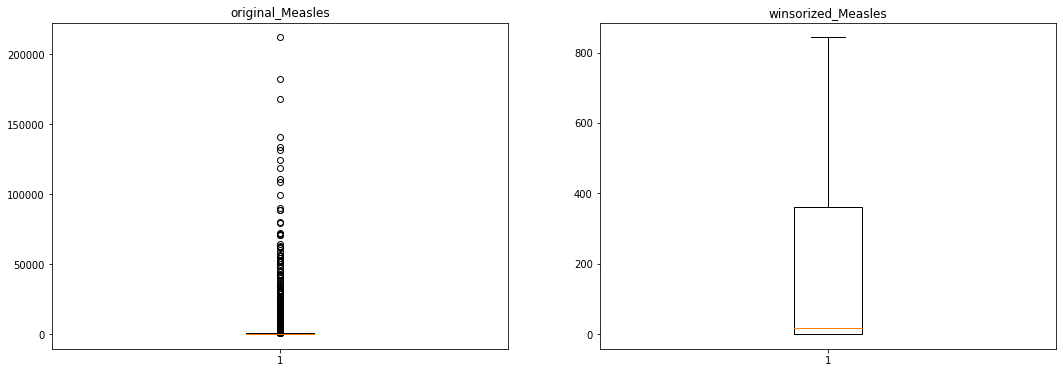

In [75]:
# Winsorize Measles
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Measles = df_life_expectancy_5['measles']
plt.boxplot(original_Measles)
plt.title("original_Measles")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_measles'] = winsorize(df_life_expectancy_5['measles'], (0, 0.19))
winsorized_Measles = df_life_expectancy_5['winsorized_measles']
plt.boxplot(winsorized_Measles)
plt.title("winsorized_Measles")

plt.show()

Winsorization changes 19% of the data. Be careful.

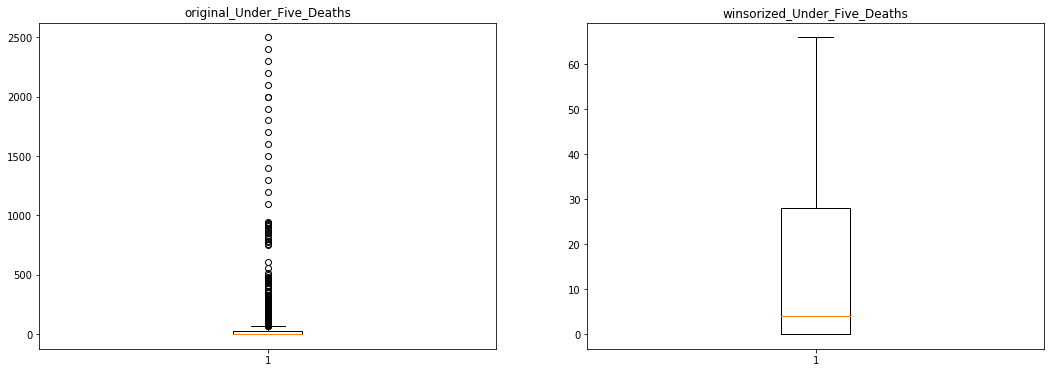

In [76]:
# Winsorize Under_Five_Deaths
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Under_Five_Deaths = df_life_expectancy_5['under_five_deaths']
plt.boxplot(original_Under_Five_Deaths)
plt.title("original_Under_Five_Deaths")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_under_five_deaths'] = winsorize(df_life_expectancy_5['under_five_deaths'], (0, 0.14))
winsorized_Under_Five_Deaths = df_life_expectancy_5['winsorized_under_five_deaths']
plt.boxplot(winsorized_Under_Five_Deaths)
plt.title("winsorized_Under_Five_Deaths")

plt.show()

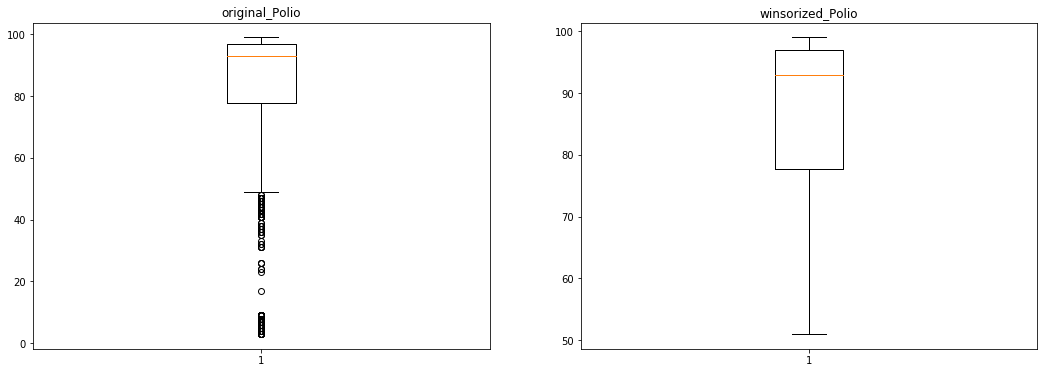

In [77]:
# Winsorize Polio
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Polio = df_life_expectancy_5['polio_perc']
plt.boxplot(original_Polio)
plt.title("original_Polio")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_polio'] = winsorize(df_life_expectancy_5['polio_perc'], (0.10, 0))
winsorized_Polio = df_life_expectancy_5['winsorized_polio']
plt.boxplot(winsorized_Polio)
plt.title("winsorized_Polio")

plt.show()

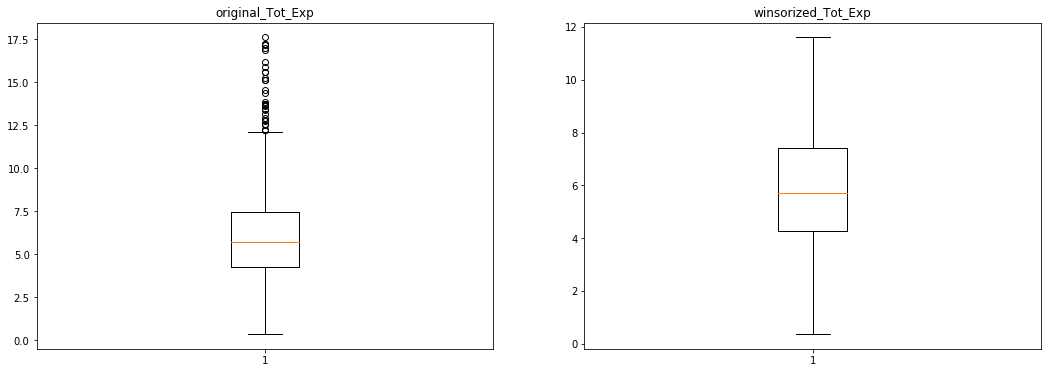

In [78]:
# Winsorize Tot_Exp
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Tot_Exp = df_life_expectancy_5['total_expenditure_perc']
plt.boxplot(original_Tot_Exp)
plt.title("original_Tot_Exp")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_tot_exp'] = winsorize(df_life_expectancy_5['total_expenditure_perc'], (0, 0.02))
winsorized_Tot_Exp = df_life_expectancy_5['winsorized_tot_exp']
plt.boxplot(winsorized_Tot_Exp)
plt.title("winsorized_Tot_Exp")

plt.show()

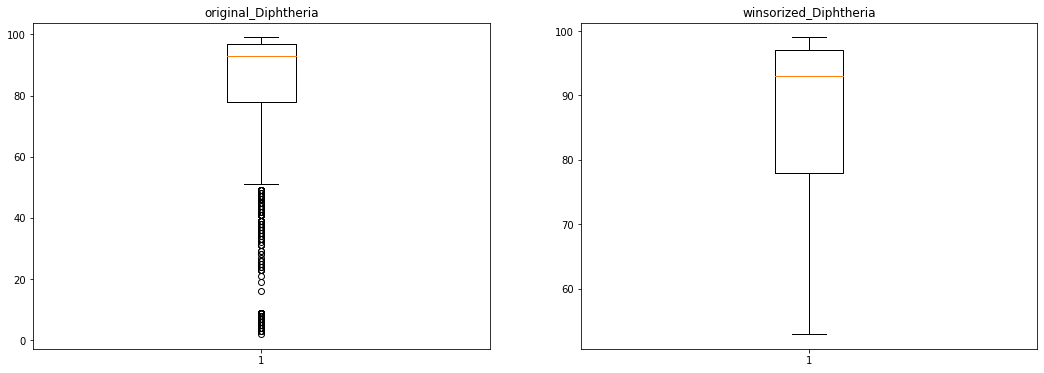

In [79]:
# Winsorize Diphtheria
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Diphtheria = df_life_expectancy_5['diphtheria_perc']
plt.boxplot(original_Diphtheria)
plt.title("original_Diphtheria")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_diphtheria'] = winsorize(df_life_expectancy_5['diphtheria_perc'], (0.11, 0))
winsorized_Diphtheria = df_life_expectancy_5['winsorized_diphtheria']
plt.boxplot(winsorized_Diphtheria)
plt.title("winsorized_Diphtheria")

plt.show()

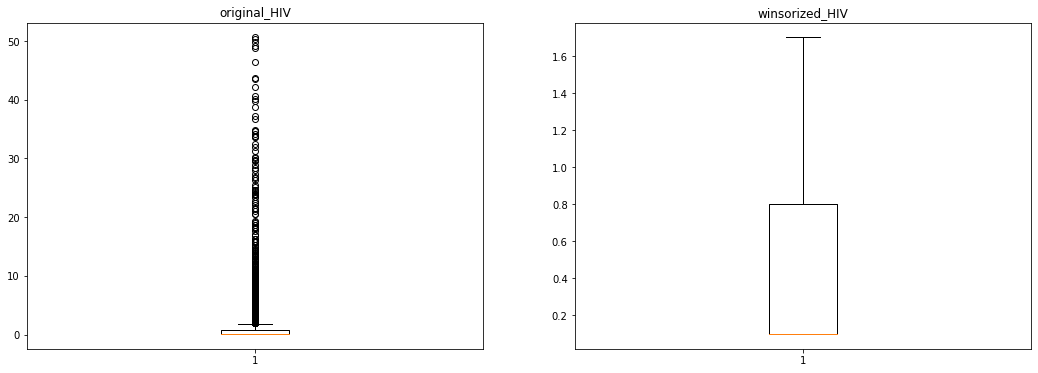

In [80]:
# Winsorize HIV/AIDS
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_HIV = df_life_expectancy_5['hiv_aids']
plt.boxplot(original_HIV)
plt.title("original_HIV")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_hiv_aids'] = winsorize(df_life_expectancy_5['hiv_aids'], (0, 0.19))
winsorized_HIV = df_life_expectancy_5['winsorized_hiv_aids']
plt.boxplot(winsorized_HIV)
plt.title("winsorized_HIV")

plt.show()

Winsorization changes 19% of the data. Be careful.

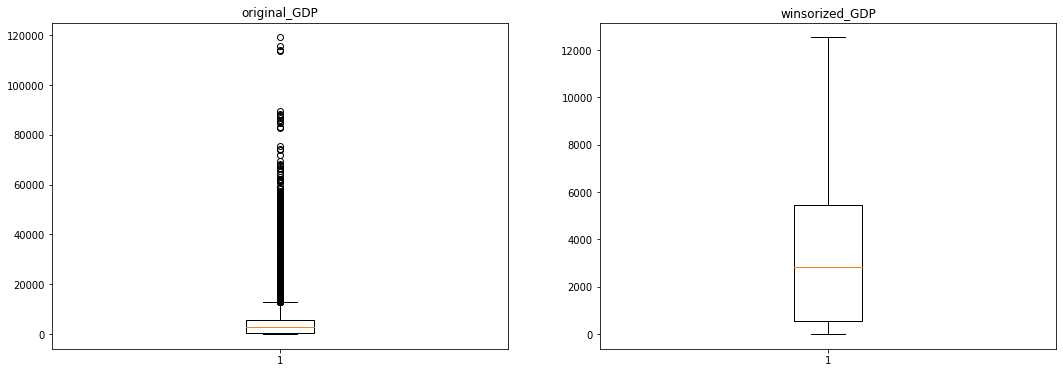

In [81]:
# Winsorize GDP
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_GDP = df_life_expectancy_5['gdp']
plt.boxplot(original_GDP)
plt.title("original_GDP")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_gdp'] = winsorize(df_life_expectancy_5['gdp'], (0,0.16))
winsorized_GDP = df_life_expectancy_5['winsorized_gdp']
plt.boxplot(winsorized_GDP)
plt.title("winsorized_GDP")

plt.show()

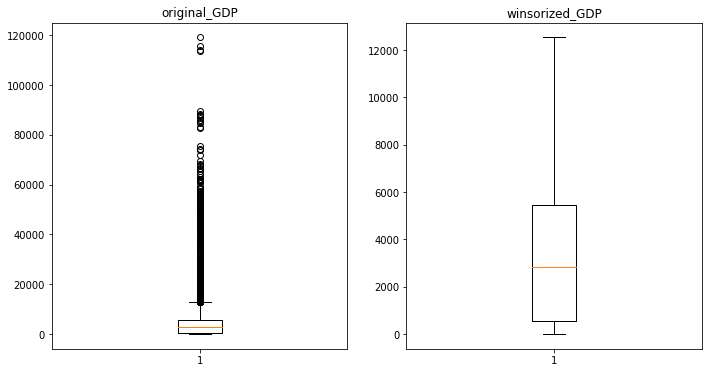

In [82]:
# Winsorize GDP
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
original_GDP = df_life_expectancy_5['gdp']
plt.boxplot(original_GDP)
plt.title("original_GDP")

plt.subplot(1,3,2)
df_life_expectancy_5['winsorized_gdp'] = winsorize(df_life_expectancy_5['gdp'], (0,0.16))
winsorized_GDP = df_life_expectancy_5['winsorized_gdp']
plt.boxplot(winsorized_GDP)
plt.title("winsorized_GDP")

plt.show()

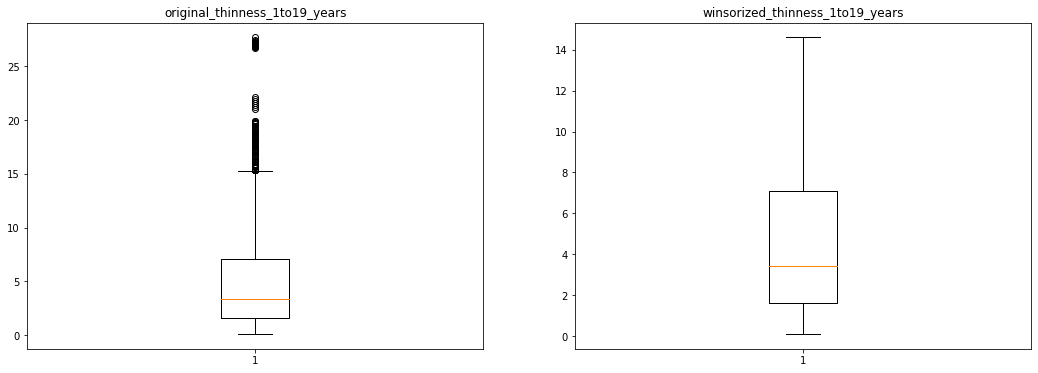

In [83]:
# Winsorize thinness_1to19_years
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_thinness_1to19_years = df_life_expectancy_5['thinness_1_19_years_perc']
plt.boxplot(original_thinness_1to19_years)
plt.title("original_thinness_1to19_years")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_thinness_1_19'] = winsorize(df_life_expectancy_5['thinness_1_19_years_perc'], (0, 0.04))
winsorized_thinness_1to19_years = df_life_expectancy_5['winsorized_thinness_1_19']
plt.boxplot(winsorized_thinness_1to19_years)
plt.title("winsorized_thinness_1to19_years")

plt.show()

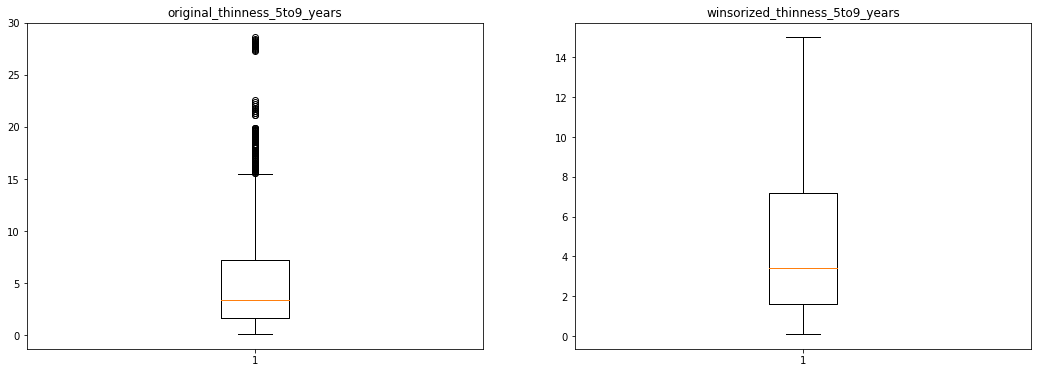

In [84]:
# Winsorize thinness_5to9_years
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_thinness_5to9_years = df_life_expectancy_5['thinness_5_9_years_perc']
plt.boxplot(original_thinness_5to9_years)
plt.title("original_thinness_5to9_years")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_thinness_5_9'] = winsorize(df_life_expectancy_5['thinness_5_9_years_perc'], (0, 0.04))
winsorized_thinness_5to9_years = df_life_expectancy_5['winsorized_thinness_5_9']
plt.boxplot(winsorized_thinness_5to9_years)
plt.title("winsorized_thinness_5to9_years")

plt.show()

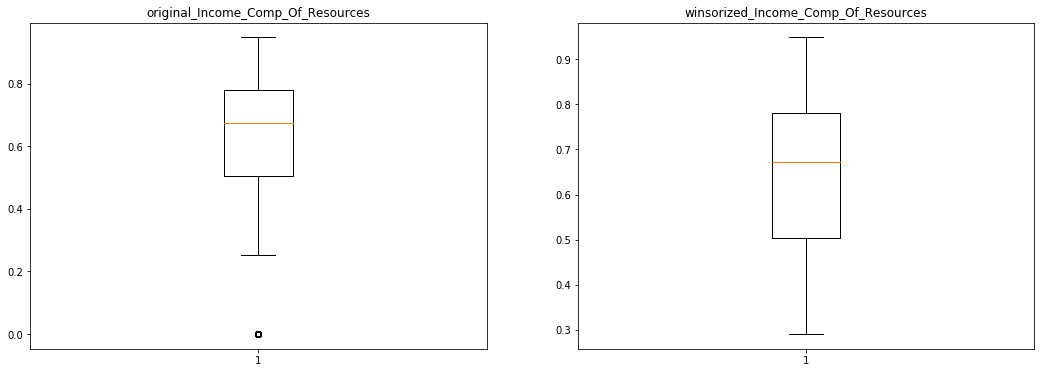

In [85]:
# Winsorize Income_Comp_Of_Resources
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Income_Comp_Of_Resources = df_life_expectancy_5['income_composition_of_resources']
plt.boxplot(original_Income_Comp_Of_Resources)
plt.title("original_Income_Comp_Of_Resources")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_income_composition_of_res'] = winsorize(df_life_expectancy_5['income_composition_of_resources'], (0.05, 0))
winsorized_Income_Comp_Of_Resources = df_life_expectancy_5['winsorized_income_composition_of_res']
plt.boxplot(winsorized_Income_Comp_Of_Resources)
plt.title("winsorized_Income_Comp_Of_Resources")

plt.show()

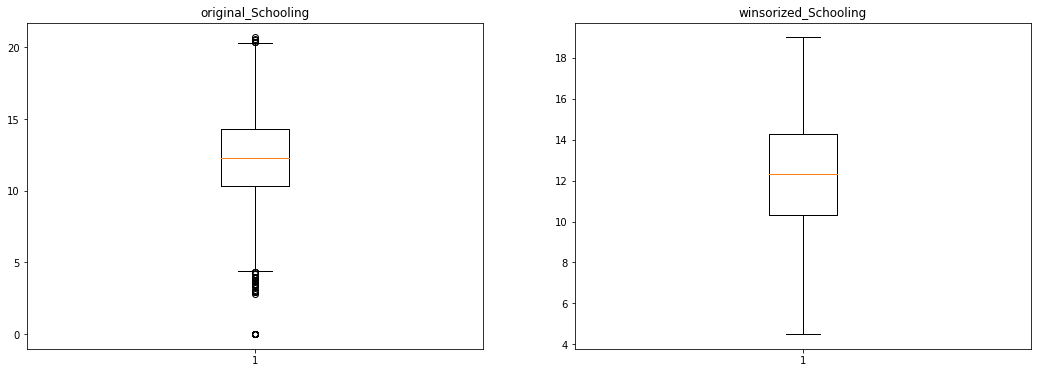

In [86]:
# Winsorize Schooling
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_Schooling = df_life_expectancy_5['schooling']
plt.boxplot(original_Schooling)
plt.title("original_Schooling")

plt.subplot(1,2,2)
df_life_expectancy_5['winsorized_schooling'] = winsorize(df_life_expectancy_5['schooling'], (0.02, 0.01))
winsorized_Schooling = df_life_expectancy_5['winsorized_schooling']
plt.boxplot(winsorized_Schooling)
plt.title("winsorized_Schooling")

plt.show()

In [87]:
df_life_expectancy_5.head()

,country,year,status,life_expectancy_age,adult_mortality_rate,infant_deaths,alcohol,percentage_expenditure,hepatitis_b_perc,measles,bmi,under_five_deaths,polio_perc,total_expenditure_perc,diphtheria_perc,hiv_aids,gdp,thinness_1_19_years_perc,thinness_5_9_years_perc,income_composition_of_resources,schooling,winsorized_life_expectancy,winsorized_adult_mortality,winsorized_infant_deaths,winsorized_alcohol,winsorized_perc_exp,log_perc_exp,winsorized_hep_b,winsorized_measles,winsorized_under_five_deaths,winsorized_polio,winsorized_tot_exp,winsorized_diphtheria,winsorized_hiv_aids,winsorized_gdp,winsorized_thinness_1_19,winsorized_thinness_5_9,winsorized_income_composition_of_res,winsorized_schooling
0,Afghanistan,2015,Developing,65,263.00,62.00,0.01,71.28,65.00,1154.00,19.10,83.00,6.00,8.16,65.00,0.10,584.26,17.20,17.30,0.48,10.10,65,263.00,55.00,0.01,71.28,4.27,65.00,843.00,66.00,51.00,8.16,65.00,0.10,584.26,14.60,15.00,0.48,10.10
1,Afghanistan,2014,Developing,59,271.00,64.00,0.01,73.52,62.00,492.00,18.60,86.00,58.00,8.18,62.00,0.10,612.70,17.50,17.50,0.48,10.00,59,271.00,55.00,0.01,73.52,4.30,62.00,492.00,66.00,58.00,8.18,62.00,0.10,612.70,14.60,15.00,0.48,10.00
2,Afghanistan,2013,Developing,59,268.00,66.00,0.01,73.22,64.00,430.00,18.10,89.00,62.00,8.13,64.00,0.10,631.74,17.70,17.70,0.47,9.90,59,268.00,55.00,0.01,73.22,4.29,64.00,430.00,66.00,62.00,8.13,64.00,0.10,631.74,14.60,15.00,0.47,9.90
3,Afghanistan,2012,Developing,59,272.00,69.00,0.01,78.18,67.00,2787.00,17.60,93.00,67.00,8.52,67.00,0.10,669.96,17.90,18.00,0.46,9.80,59,272.00,55.00,0.01,78.18,4.36,67.00,843.00,66.00,67.00,8.52,67.00,0.10,669.96,14.60,15.00,0.46,9.80
4,Afghanistan,2011,Developing,59,275.00,71.00,0.01,7.10,68.00,3013.00,17.20,97.00,68.00,7.87,68.00,0.10,63.54,18.20,18.20,0.45,9.50,59,275.00,55.00,0.01,7.10,1.96,68.00,843.00,66.00,68.00,7.87,68.00,0.10,63.54,14.60,15.00,0.45,9.50


In [88]:
# Check number of Outliers after Winsorization for each variable.

# list of only winsorized columns
win_list = [col for col in df_life_expectancy_5 if col.startswith('winsorized')]
    
# Calculate number of outliers and its percentage in each variable using Tukey's method.

for variable in win_list:
    q75, q25 = np.percentile(df_life_expectancy_5[variable], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and {}".format(variable,
                                                                             len((np.where((df_life_expectancy_5[variable] > max_val) | 
                                                                                           (df_life_expectancy_5[variable] < min_val))[0])),len((np.where((df_life_expectancy_5[variable] > max_val) | 
                                                                                           (df_life_expectancy_5[variable] < min_val))[0]))*100/1987))

Number of outliers and percentage of it in winsorized_life_expectancy : 0 and 0.0
Number of outliers and percentage of it in winsorized_adult_mortality : 0 and 0.0
Number of outliers and percentage of it in winsorized_infant_deaths : 0 and 0.0
Number of outliers and percentage of it in winsorized_alcohol : 0 and 0.0
Number of outliers and percentage of it in winsorized_perc_exp : 0 and 0.0
Number of outliers and percentage of it in winsorized_hep_b : 0 and 0.0
Number of outliers and percentage of it in winsorized_measles : 0 and 0.0
Number of outliers and percentage of it in winsorized_under_five_deaths : 0 and 0.0
Number of outliers and percentage of it in winsorized_polio : 0 and 0.0
Number of outliers and percentage of it in winsorized_tot_exp : 0 and 0.0
Number of outliers and percentage of it in winsorized_diphtheria : 0 and 0.0
Number of outliers and percentage of it in winsorized_hiv_aids : 0 and 0.0
Number of outliers and percentage of it in winsorized_gdp : 0 and 0.0
Number of

### Moving on to exploratory analysis

In [89]:
df_life_expectancy_5.describe()

,year,life_expectancy_age,adult_mortality_rate,infant_deaths,alcohol,percentage_expenditure,hepatitis_b_perc,measles,bmi,under_five_deaths,polio_perc,total_expenditure_perc,diphtheria_perc,hiv_aids,gdp,thinness_1_19_years_perc,thinness_5_9_years_perc,income_composition_of_resources,schooling,winsorized_life_expectancy,winsorized_adult_mortality,winsorized_infant_deaths,winsorized_alcohol,winsorized_perc_exp,log_perc_exp,winsorized_hep_b,winsorized_measles,winsorized_under_five_deaths,winsorized_polio,winsorized_tot_exp,winsorized_diphtheria,winsorized_hiv_aids,winsorized_gdp,winsorized_thinness_1_19,winsorized_thinness_5_9,winsorized_income_composition_of_res,winsorized_schooling
count,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00,2928.00
mean,2007.50,68.82,164.80,30.41,4.61,740.32,78.92,2427.86,38.20,42.18,82.39,5.91,82.18,1.75,7246.68,4.86,4.89,0.63,12.03,68.84,161.91,13.68,4.59,271.78,-inf,81.57,223.73,17.48,85.30,5.87,85.47,0.51,4062.67,4.70,4.72,0.64,12.07
std,4.61,9.55,124.29,118.11,4.03,1990.93,24.54,11485.97,19.85,160.70,23.46,2.44,23.73,5.09,13437.25,4.40,4.49,0.21,3.30,9.51,115.42,19.12,3.99,363.52,nan,17.98,333.73,24.09,15.63,2.33,15.12,0.64,4352.62,3.86,3.92,0.17,3.14
min,2000.00,36.00,1.00,0.00,0.01,0.00,1.00,0.00,1.00,0.00,3.00,0.37,2.00,0.10,1.68,0.10,0.10,0.00,0.00,45.00,1.00,0.00,0.01,0.00,-inf,44.00,0.00,0.00,51.00,0.37,53.00,0.10,1.68,0.10,0.10,0.29,4.50
25%,2003.75,63.00,74.00,0.00,0.95,4.85,73.50,0.00,19.40,0.00,77.75,4.28,78.00,0.10,560.98,1.60,1.60,0.50,10.30,63.00,74.00,0.00,0.95,4.85,1.58,73.50,0.00,0.00,77.75,4.28,78.00,0.10,560.98,1.60,1.60,0.50,10.30
50%,2007.50,72.00,144.00,3.00,3.70,65.61,88.00,17.00,43.00,4.00,93.00,5.71,93.00,0.10,2832.34,3.40,3.40,0.67,12.30,72.00,144.00,3.00,3.70,65.61,4.18,88.00,17.00,4.00,93.00,5.71,93.00,0.10,2832.34,3.40,3.40,0.67,12.30
75%,2011.25,75.00,228.00,22.00,7.68,442.61,96.00,362.25,56.10,28.00,97.00,7.43,97.00,0.80,5453.28,7.10,7.20,0.78,14.30,75.00,228.00,22.00,7.68,442.61,6.09,96.00,362.25,28.00,97.00,7.43,97.00,0.80,5453.28,7.10,7.20,0.78,14.30
max,2015.00,89.00,723.00,1800.00,17.87,19479.91,99.00,212183.00,77.60,2500.00,99.00,17.60,99.00,50.60,119172.74,27.70,28.60,0.95,20.70,89.00,453.00,55.00,13.47,1003.37,9.88,99.00,843.00,66.00,99.00,11.60,99.00,1.70,12538.18,14.60,15.00,0.95,19.00


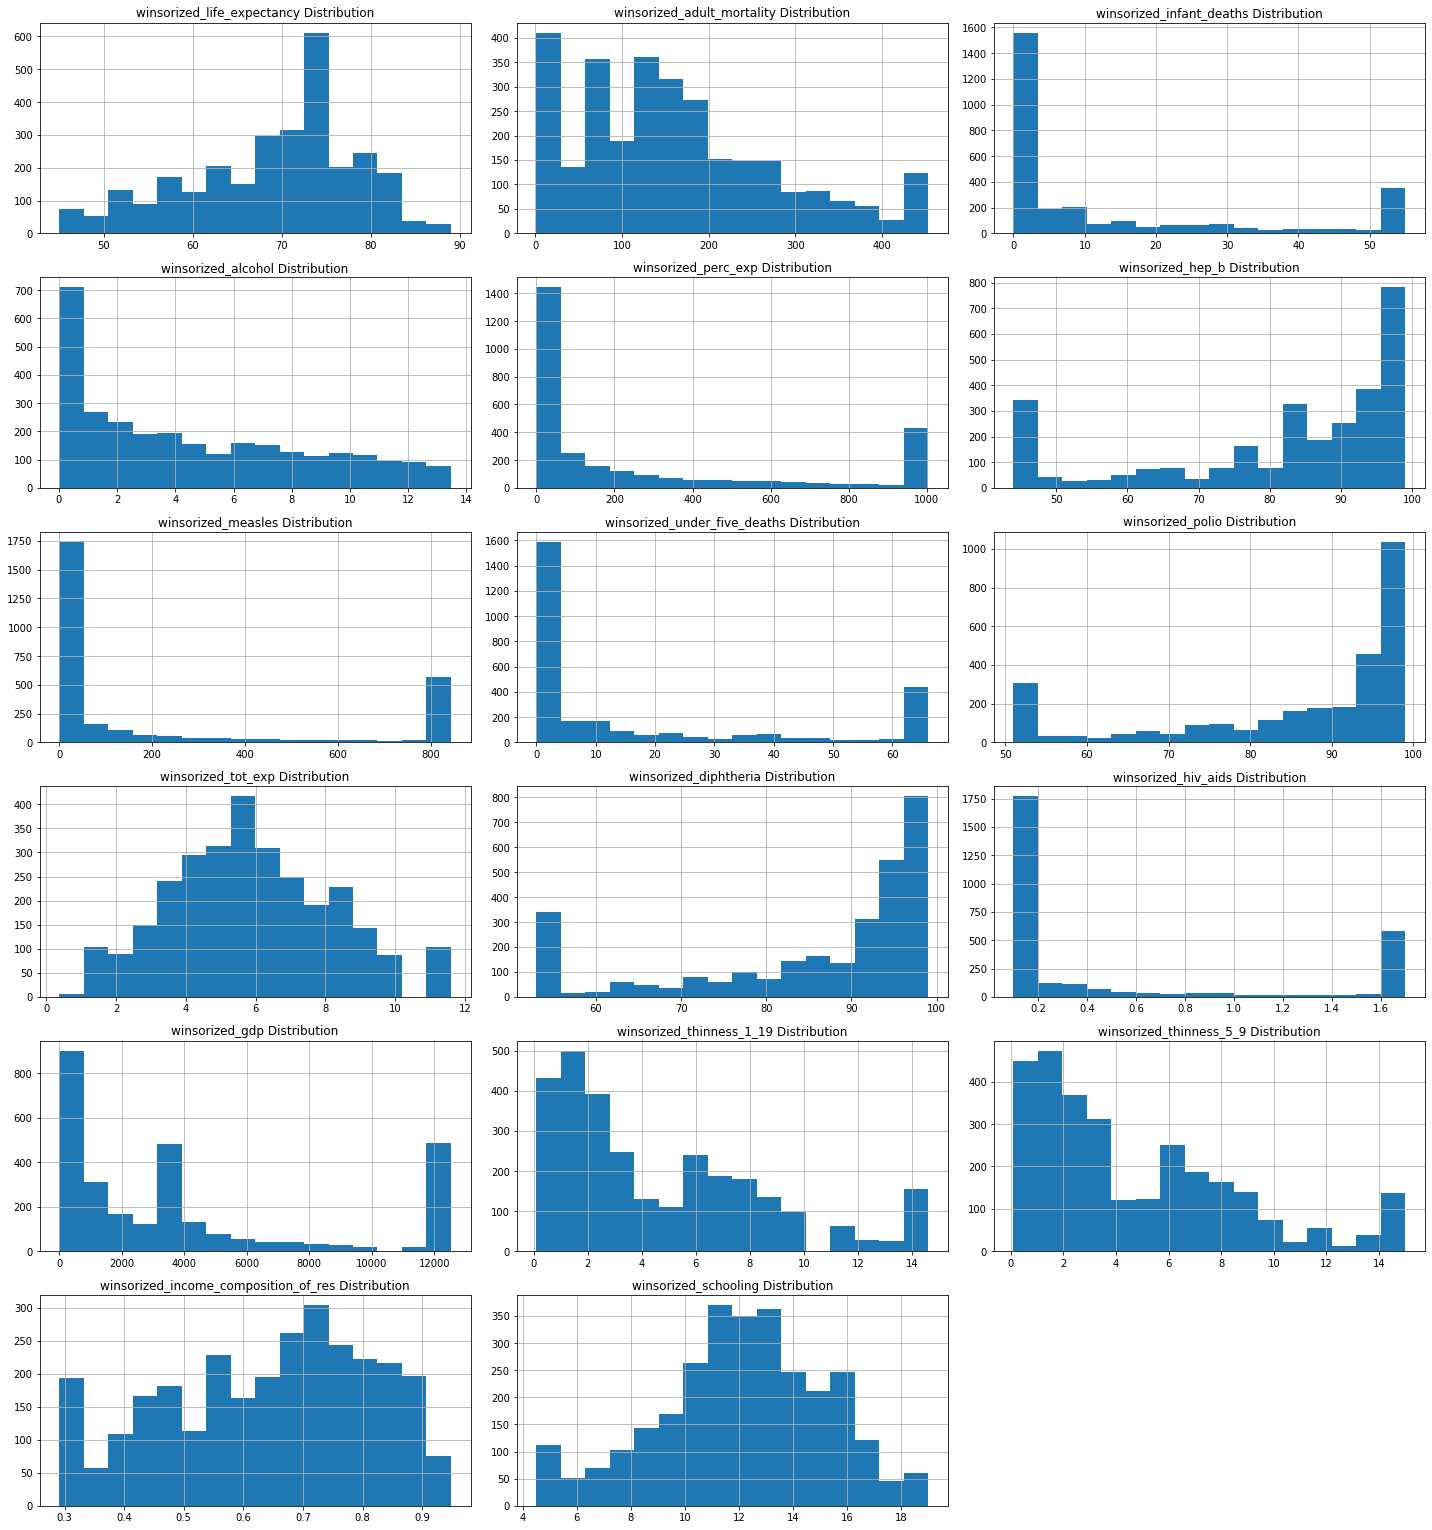

In [90]:
# Univariate visualization without having to manually plot each graph
# notice: the list of columns is referencing only the floats

def draw_histograms(df, columns, n_rows, n_cols):
    fig=plt.figure(figsize =(20, 60))
    for i, var_name in enumerate(columns):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=16,ax=ax)
        ax.set_title(var_name + " Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()
    
draw_histograms(df_life_expectancy_5, win_list, len(win_list), 3)

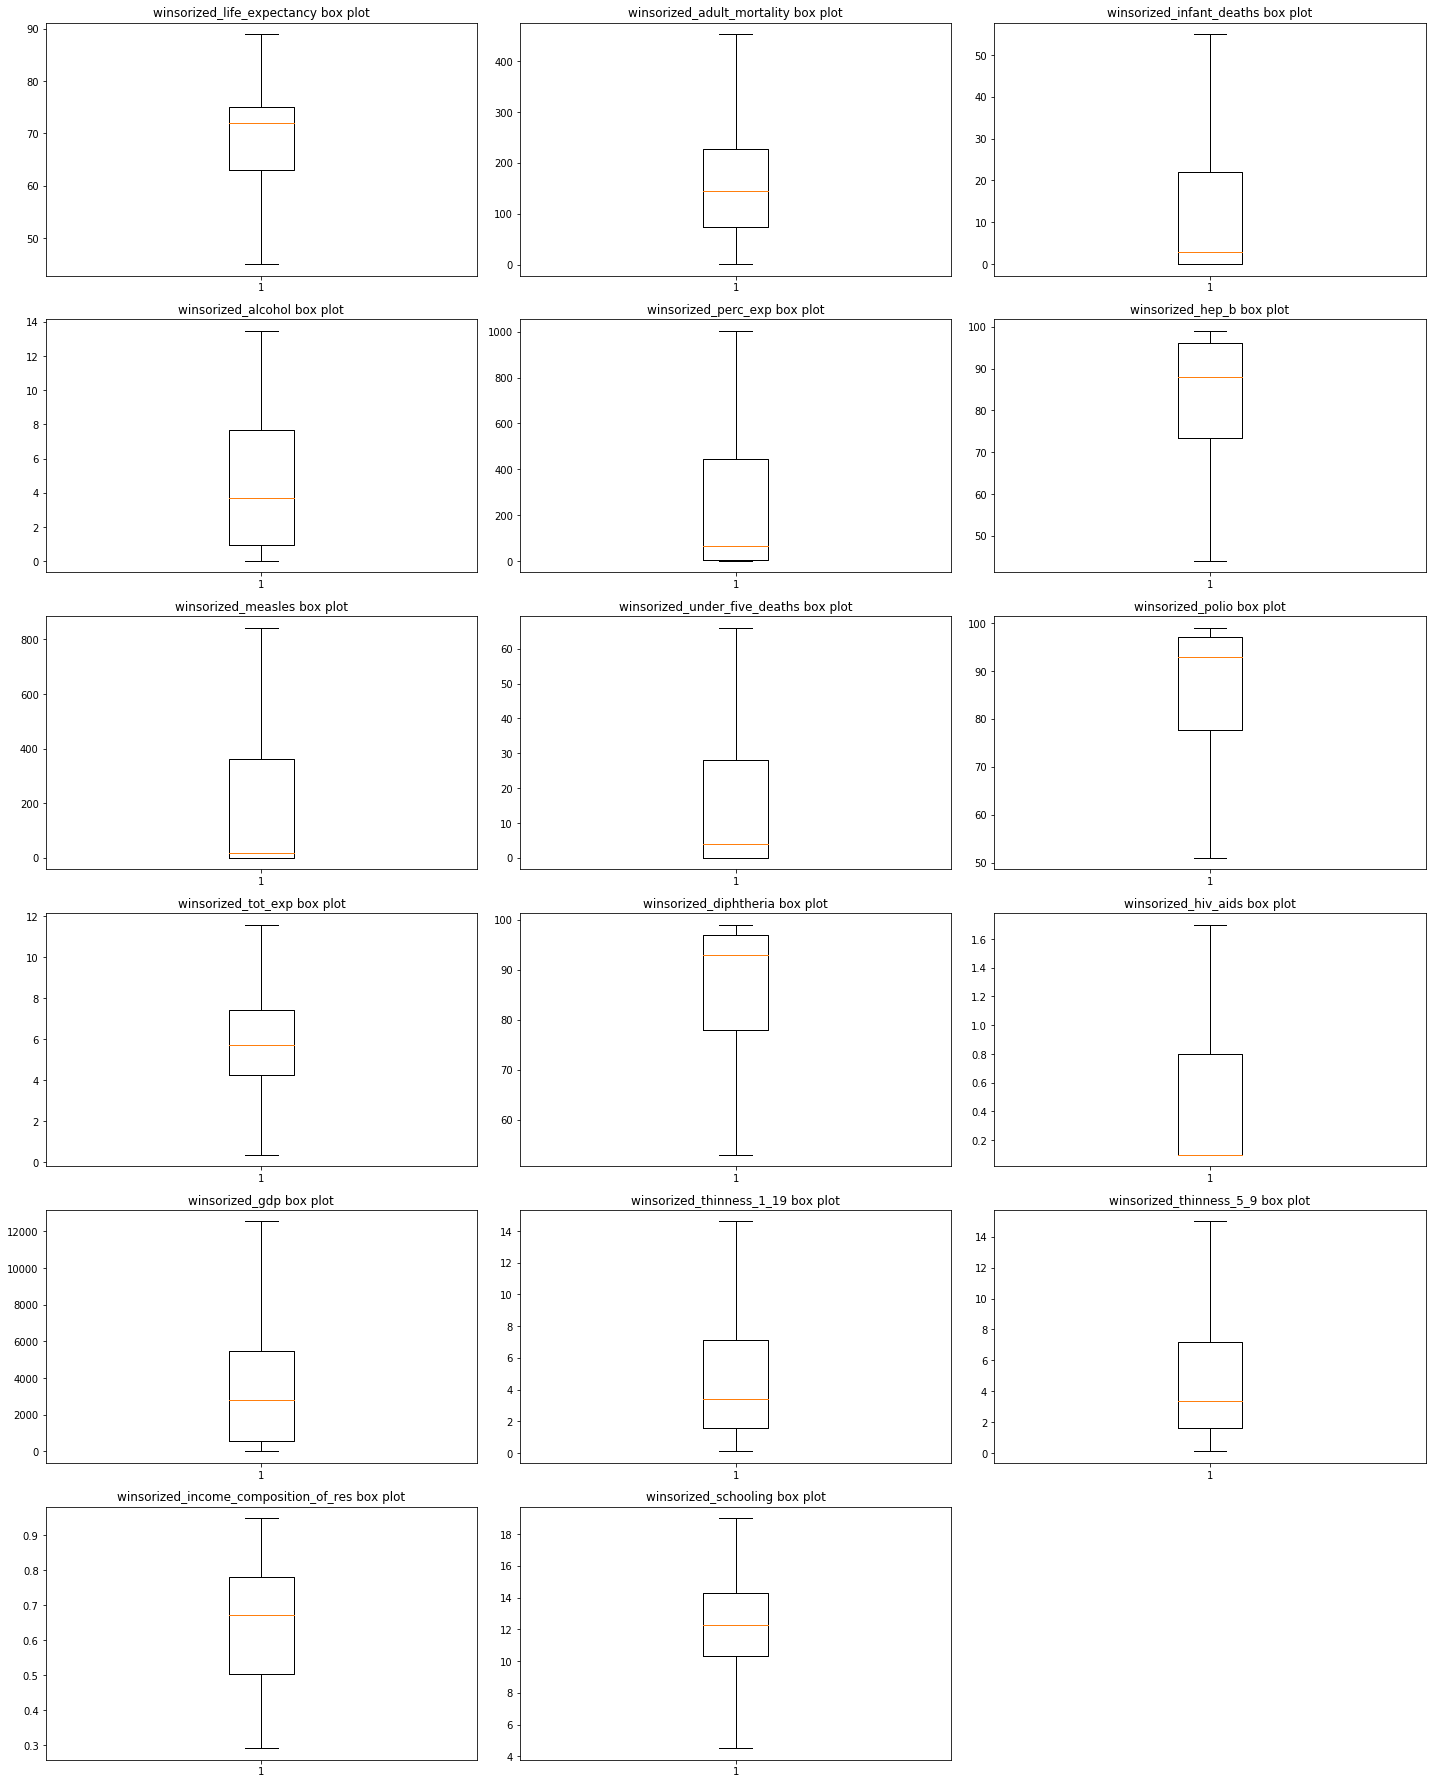

In [91]:
# box plots of all float data for df_life_expectancy_5 

def draw_box(df, columns, n_rows, n_cols):
    fig=plt.figure(figsize =(20, 70))
    for i, var_name in enumerate(columns):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        ax.boxplot(df[var_name])
        ax.set_title(var_name + ' box plot')
    fig.tight_layout()
    plt.show()
    
draw_box(df_life_expectancy_5, win_list, len(win_list), 3)


In [92]:
# Descriptive statistics of categorical variables.
df_life_expectancy_5.describe(include=['O'])

,country,status
count,2928,2928
unique,183,2
top,Malta,Developing
freq,16,2322


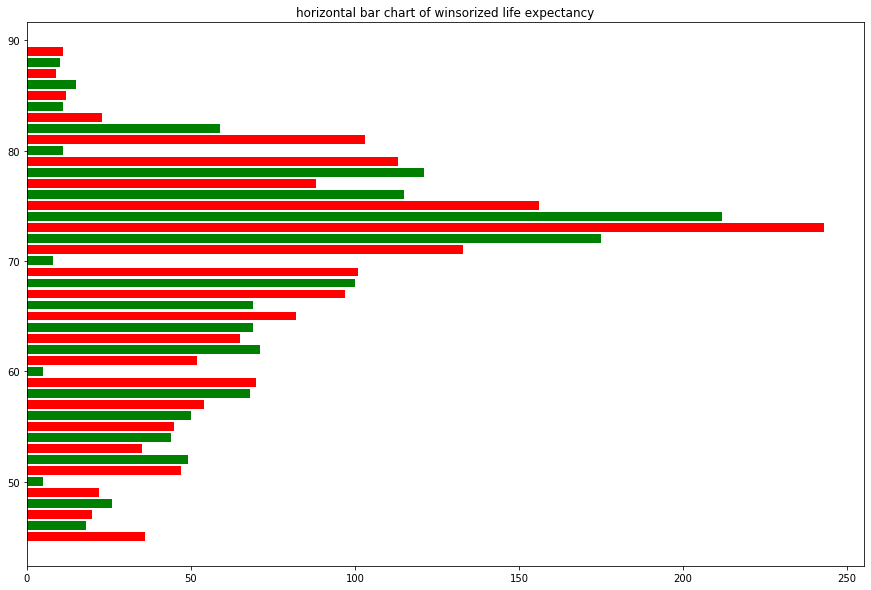

In [93]:
# bar chart of status
# notice: the majority of countries are classified as 'developing'
plt.figure(figsize=(15,10))
plt.barh(df_life_expectancy_5.groupby("winsorized_life_expectancy")["winsorized_life_expectancy"].count().index, 
        df_life_expectancy_5.groupby("winsorized_life_expectancy")["winsorized_life_expectancy"].count(), 
        color=["red","green"])
plt.title("horizontal bar chart of winsorized life expectancy")
plt.show()

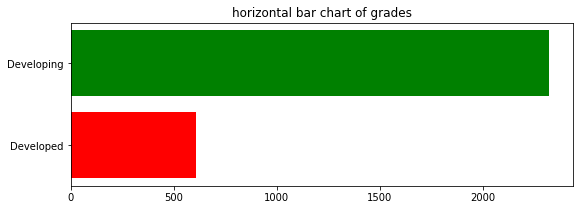

In [94]:
# bar chart of status
# notice: the majority of countries are classified as 'developing'
plt.figure(figsize=(9,3))
plt.barh(df_life_expectancy_5.groupby("status")["winsorized_life_expectancy"].count().index, 
        df_life_expectancy_5.groupby("status")["status"].count(), 
        color=["red","green"])
plt.title("horizontal bar chart of grades")
plt.show()

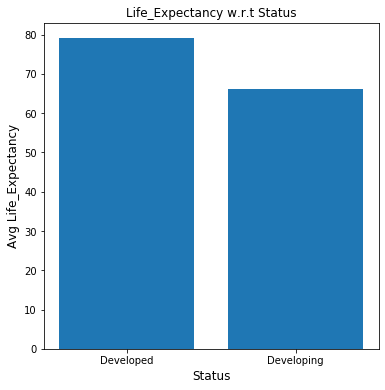

In [95]:
# Life_Expectancy w.r.t Status using bar plot.
plt.figure(figsize=(6,6))
plt.bar(df_life_expectancy_5.groupby('status')['status'].count().index,df_life_expectancy_5.groupby('status')['winsorized_life_expectancy'].mean())
plt.xlabel("Status",fontsize=12)
plt.ylabel("Avg Life_Expectancy",fontsize=12)
plt.title("Life_Expectancy w.r.t Status")
plt.show()


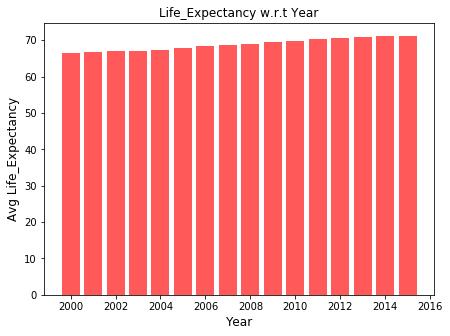

In [96]:
plt.figure(figsize=(7,5))
plt.bar(df_life_expectancy_5.groupby('year')['year'].count().index,df_life_expectancy_5.groupby('year')['winsorized_life_expectancy'].mean(),color='red',alpha=0.65)
plt.xlabel("Year",fontsize=12)
plt.ylabel("Avg Life_Expectancy",fontsize=12)
plt.title("Life_Expectancy w.r.t Year")
plt.show()

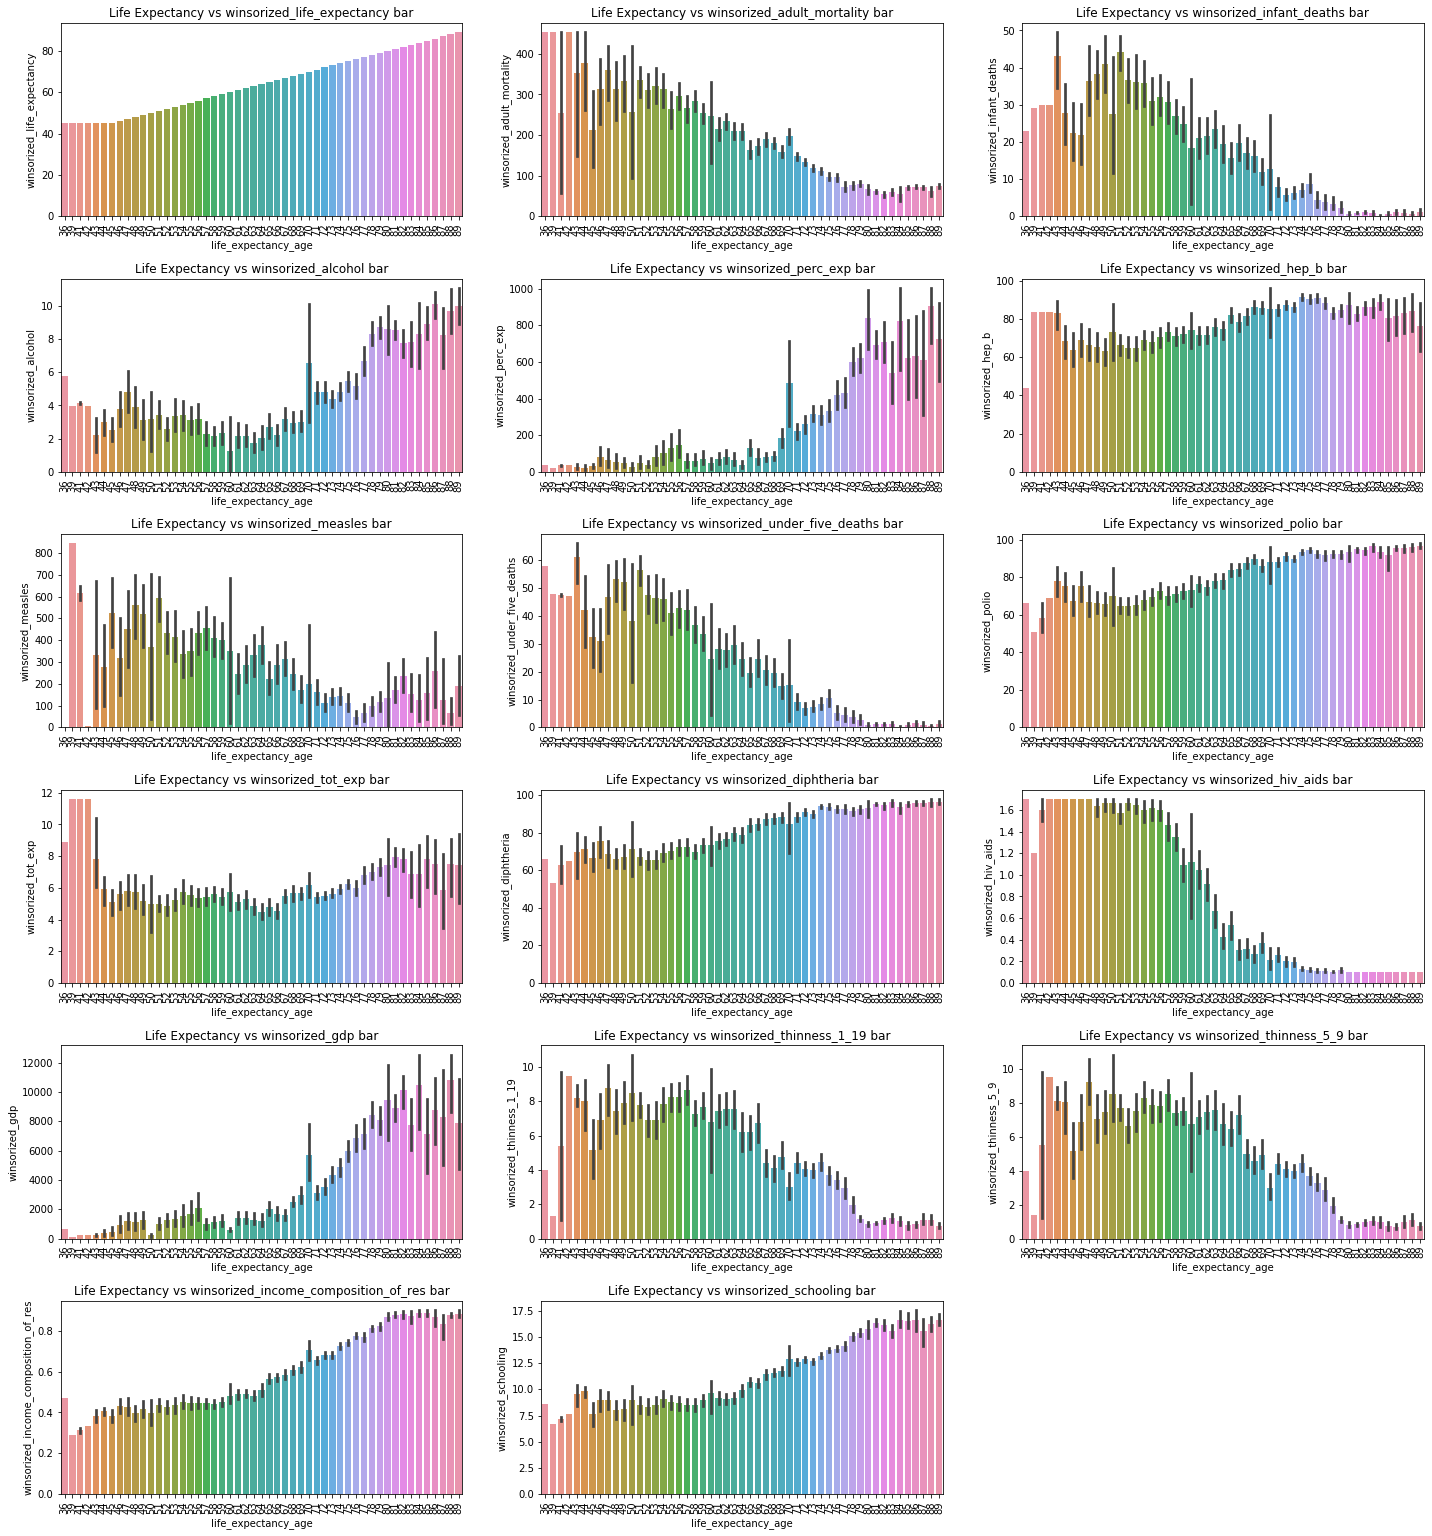

In [97]:
# Univariate visualization without having to manually plot each graph
# notice: the list of columns is referencing only the floats

def draw_bars(df, columns, n_rows, n_cols):
    fig=plt.figure(figsize =(20, 60))
    for i, var_name in enumerate(columns):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        sns.barplot(df['life_expectancy_age'], df[var_name])
        ax.set_title('Life Expectancy vs ' + str(var_name) + " bar")
        plt.xticks(rotation=90)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()
    
draw_bars(df_life_expectancy_5, win_list, len(win_list), 3)

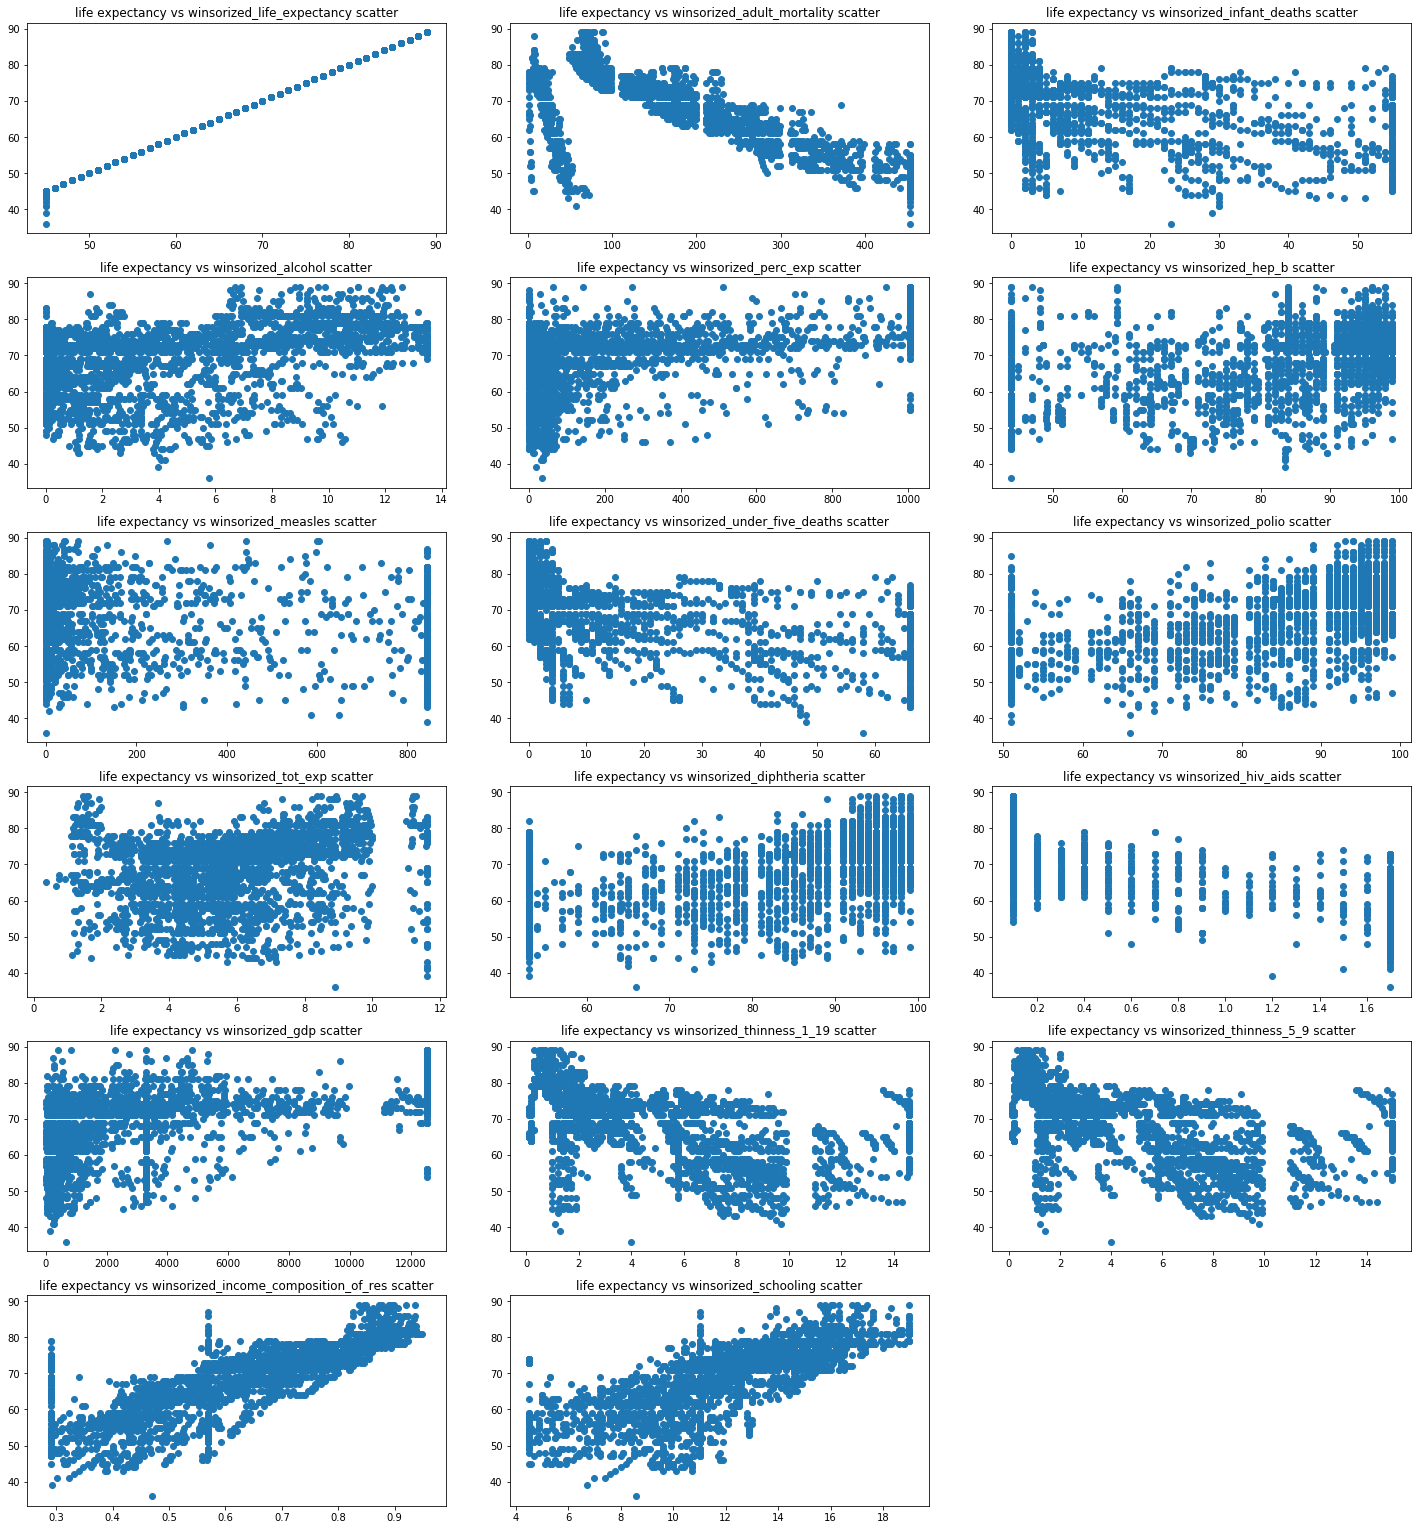

In [98]:
# Univariate visualization without having to manually plot each graph
# notice: the list of columns is referencing only the floats
#winsorized_df_list = new_winsorized_life.columns

def draw_scatters(df, columns, n_rows, n_cols):
    fig=plt.figure(figsize =(20, 60))
    for i, var_name in enumerate(columns):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        ax.scatter(df[var_name], df['life_expectancy_age'])
        ax.set_title('life expectancy vs ' + str(var_name) + " scatter")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()
    
draw_scatters(df_life_expectancy_5, win_list, len(win_list), 3)

Schooling and income composition appear to have a positive relationship with life expectancy.
Vaccination columns (polio, hep b, and diptheria) appear to have simliar positive relationships with life expectancy, but all seem fairly loose. <br>
Deaths under 5, adult mortality, and both thinness variables appear to have a negative relationship with life expectancy.

In [99]:
# create list of columns, keeping only winsorized columns
cols = [col for col in df_life_expectancy_5 if col.startswith('winsorized')]

In [100]:
# create new dataframe from column list
wins_df_le = df_life_expectancy_5[cols]

In [101]:
# add missing columns (year, status, country)
wins_df_le['year'] = df_life_expectancy_5['year']
wins_df_le['status'] = df_life_expectancy_5['status']
wins_df_le['country'] = df_life_expectancy_5['country']
wins_df_le.head()

,winsorized_life_expectancy,winsorized_adult_mortality,winsorized_infant_deaths,winsorized_alcohol,winsorized_perc_exp,winsorized_hep_b,winsorized_measles,winsorized_under_five_deaths,winsorized_polio,winsorized_tot_exp,winsorized_diphtheria,winsorized_hiv_aids,winsorized_gdp,winsorized_thinness_1_19,winsorized_thinness_5_9,winsorized_income_composition_of_res,winsorized_schooling,year,status,country
0,65,263.00,55.00,0.01,71.28,65.00,843.00,66.00,51.00,8.16,65.00,0.10,584.26,14.60,15.00,0.48,10.10,2015,Developing,Afghanistan
1,59,271.00,55.00,0.01,73.52,62.00,492.00,66.00,58.00,8.18,62.00,0.10,612.70,14.60,15.00,0.48,10.00,2014,Developing,Afghanistan
2,59,268.00,55.00,0.01,73.22,64.00,430.00,66.00,62.00,8.13,64.00,0.10,631.74,14.60,15.00,0.47,9.90,2013,Developing,Afghanistan
3,59,272.00,55.00,0.01,78.18,67.00,843.00,66.00,67.00,8.52,67.00,0.10,669.96,14.60,15.00,0.46,9.80,2012,Developing,Afghanistan
4,59,275.00,55.00,0.01,7.10,68.00,843.00,66.00,68.00,7.87,68.00,0.10,63.54,14.60,15.00,0.45,9.50,2011,Developing,Afghanistan


In [102]:
wins_df_le.corr()

,winsorized_life_expectancy,winsorized_adult_mortality,winsorized_infant_deaths,winsorized_alcohol,winsorized_perc_exp,winsorized_hep_b,winsorized_measles,winsorized_under_five_deaths,winsorized_polio,winsorized_tot_exp,winsorized_diphtheria,winsorized_hiv_aids,winsorized_gdp,winsorized_thinness_1_19,winsorized_thinness_5_9,winsorized_income_composition_of_res,winsorized_schooling,year
winsorized_life_expectancy,1.00,-0.69,-0.57,0.41,0.49,0.37,-0.34,-0.60,0.58,0.24,0.59,-0.79,0.55,-0.53,-0.52,0.81,0.76,0.17
winsorized_adult_mortality,-0.69,1.00,0.38,-0.21,-0.32,-0.22,0.21,0.41,-0.37,-0.14,-0.37,0.60,-0.36,0.35,0.36,-0.54,-0.48,-0.07
winsorized_infant_deaths,-0.57,0.38,1.00,-0.34,-0.35,-0.32,0.58,0.99,-0.43,-0.17,-0.42,0.42,-0.36,0.43,0.45,-0.49,-0.52,-0.04
winsorized_alcohol,0.41,-0.21,-0.34,1.00,0.37,0.13,-0.20,-0.35,0.28,0.32,0.28,-0.20,0.48,-0.46,-0.45,0.52,0.56,-0.05
winsorized_perc_exp,0.49,-0.32,-0.35,0.37,1.00,0.13,-0.20,-0.36,0.27,0.19,0.28,-0.30,0.75,-0.34,-0.34,0.54,0.52,0.04
winsorized_hep_b,0.37,-0.22,-0.32,0.13,0.13,1.00,-0.27,-0.33,0.66,0.12,0.70,-0.35,0.19,-0.16,-0.17,0.33,0.34,0.17
winsorized_measles,-0.34,0.21,0.58,-0.20,-0.20,-0.27,1.00,0.58,-0.31,-0.16,-0.31,0.23,-0.21,0.36,0.36,-0.28,-0.33,-0.12
winsorized_under_five_deaths,-0.60,0.41,0.99,-0.35,-0.36,-0.33,0.58,1.00,-0.45,-0.17,-0.45,0.46,-0.38,0.45,0.46,-0.52,-0.55,-0.05
winsorized_polio,0.58,-0.37,-0.43,0.28,0.27,0.66,-0.31,-0.45,1.00,0.19,0.86,-0.49,0.34,-0.29,-0.29,0.53,0.52,0.12
winsorized_tot_exp,0.24,-0.14,-0.17,0.32,0.19,0.12,-0.16,-0.17,0.19,1.00,0.20,-0.12,0.19,-0.30,-0.31,0.22,0.30,0.08


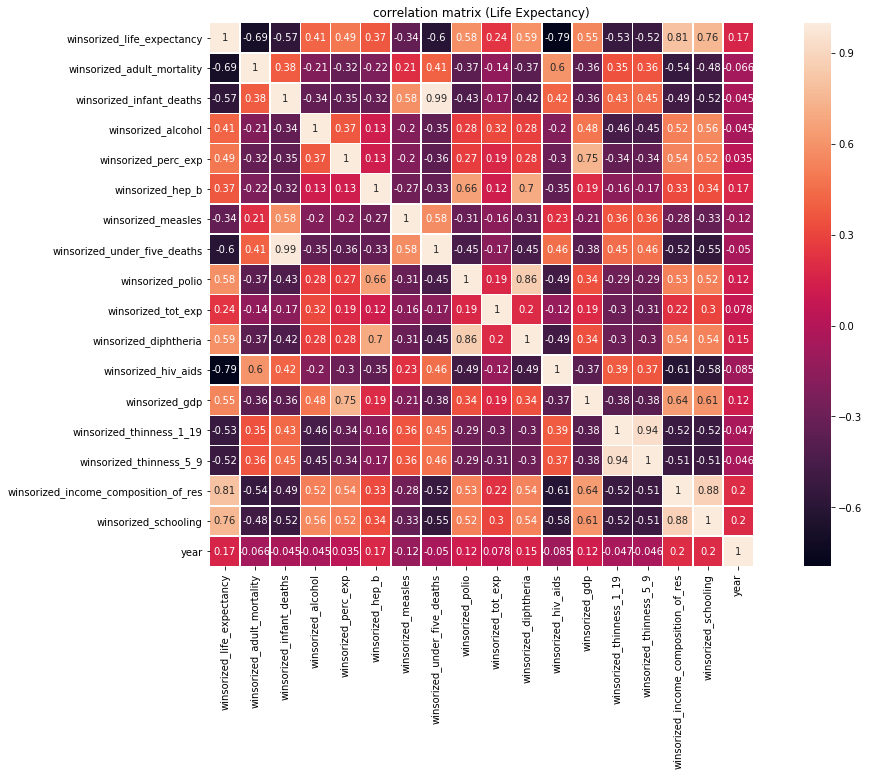

In [103]:
# plot correlation matrix visual
corrmat_life = wins_df_le.corr()

plt.figure(figsize= (40,10))

plt.subplot(1,2,1)
# draw the heatmap using seaborn.
sns.heatmap(corrmat_life, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Life Expectancy)")

plt.show()

New observations:

1) life expectancy is correlated with schooling, income comp of res, and loosely correlated with the various vaccinations. <br>
2) life expectancy has a negative relationship with HIV, adult mortality, and children deaths. <br>
3) all 3 vaccinations appear to have a correlation with each other. <br>
4) measles and children deaths appear correlated. <br>
5) total expenditure and year are correlated...perhaps inflation? or general trend of budgets over time? <br>
6) income comp of res and schooling are correlated

Since the status variable only contains two different values, it is likely best to compare a number of descriptive statistics for those two values with respect to all the other continuous variables.

In [104]:
round(wins_df_le[['status','winsorized_life_expectancy']].groupby(['status']).mean(),2)

,winsorized_life_expectancy
status,
Developed,79.10
Developing,66.16


Seems like there's a difference in life expectancy. Time to follow up with some stats.

In [106]:
# Confirming the significance of difference of Average_Life_Expectancy between Developed and Developing countries using 
# t-test

stats.ttest_ind(wins_df_le.loc[wins_df_le['status']=='Developed','winsorized_life_expectancy'],wins_df_le.loc[wins_df_le['status']=='Developing','winsorized_life_expectancy'])

Ttest_indResult(statistic=35.71307124274771, pvalue=3.610896395601235e-232)

p value is < 0.05
Hence, the difference of Average_Life_Expectancy between Developed and Developing countries is significant. We can consider 'Status' as a feature as it is related to Life Expectancy.

In [107]:
wins_df_cols = list(wins_df_le.columns)
interested_vars = [wins_df_cols[2]]
for col in wins_df_cols[4:]:
    interested_vars.append(col)

In [108]:
wins_df_le[interested_vars].groupby('status').agg('mean')

,winsorized_infant_deaths,winsorized_perc_exp,winsorized_hep_b,winsorized_measles,winsorized_under_five_deaths,winsorized_polio,winsorized_tot_exp,winsorized_diphtheria,winsorized_hiv_aids,winsorized_gdp,winsorized_thinness_1_19,winsorized_thinness_5_9,winsorized_income_composition_of_res,winsorized_schooling,year
status,,,,,,,,,,,,,,,
Developed,1.45,617.47,85.68,127.00,1.74,94.49,7.33,94.53,0.10,9108.09,1.37,1.33,0.86,15.84,2007.72
Developing,16.87,181.57,80.50,248.97,21.59,82.90,5.49,83.10,0.62,2745.91,5.57,5.61,0.59,11.08,2007.44


From the above, it appears that many of these values are likely correlated to whether a country is 'Developed' or 'Developing'. Again, t-tests are the best way to find out if differences are significant here.

In [110]:
developed_df = wins_df_le[wins_df_le.status == 'Developed']
developing_df = wins_df_le[wins_df_le.status == 'Developing']
for col in interested_vars[1:]:
    print(5*'-' + str(col) + ' Developed/Developing t-test comparison' + 5*'-')
    print('p-value=' +str(stats.ttest_ind(developed_df[col], developing_df[col], equal_var=False)[1]))

-----winsorized_perc_exp Developed/Developing t-test comparison-----
p-value=6.612481842505442e-93
-----winsorized_hep_b Developed/Developing t-test comparison-----
p-value=2.020929138872192e-12
-----winsorized_measles Developed/Developing t-test comparison-----
p-value=2.1015717355392628e-22
-----winsorized_under_five_deaths Developed/Developing t-test comparison-----
p-value=4.9100150876893756e-225
-----winsorized_polio Developed/Developing t-test comparison-----
p-value=2.212858544252606e-141
-----winsorized_tot_exp Developed/Developing t-test comparison-----
p-value=1.1364711406567185e-47
-----winsorized_diphtheria Developed/Developing t-test comparison-----
p-value=3.5847394197011115e-137
-----winsorized_hiv_aids Developed/Developing t-test comparison-----
p-value=1.9669094867104615e-231
-----winsorized_gdp Developed/Developing t-test comparison-----
p-value=7.2061004579996e-144
-----winsorized_thinness_1_19 Developed/Developing t-test comparison-----
p-value=0.0
-----winsorized_t

TypeError: unsupported operand type(s) for /: 'str' and 'int'

Some strings were encountered in the ttest.

###  Some feature engineering

In [111]:
# Convert categorical values to numerical values using one-hot encoding for 'Status' feature.
wins_df_le = pd.concat([wins_df_le,pd.get_dummies(wins_df_le['status'])],axis=1)
wins_df_le = wins_df_le.drop('status',axis=1)
wins_df_le.head()

,winsorized_life_expectancy,winsorized_adult_mortality,winsorized_infant_deaths,winsorized_alcohol,winsorized_perc_exp,winsorized_hep_b,winsorized_measles,winsorized_under_five_deaths,winsorized_polio,winsorized_tot_exp,winsorized_diphtheria,winsorized_hiv_aids,winsorized_gdp,winsorized_thinness_1_19,winsorized_thinness_5_9,winsorized_income_composition_of_res,winsorized_schooling,year,country,Developed,Developing
0,65,263.00,55.00,0.01,71.28,65.00,843.00,66.00,51.00,8.16,65.00,0.10,584.26,14.60,15.00,0.48,10.10,2015,Afghanistan,0,1
1,59,271.00,55.00,0.01,73.52,62.00,492.00,66.00,58.00,8.18,62.00,0.10,612.70,14.60,15.00,0.48,10.00,2014,Afghanistan,0,1
2,59,268.00,55.00,0.01,73.22,64.00,430.00,66.00,62.00,8.13,64.00,0.10,631.74,14.60,15.00,0.47,9.90,2013,Afghanistan,0,1
3,59,272.00,55.00,0.01,78.18,67.00,843.00,66.00,67.00,8.52,67.00,0.10,669.96,14.60,15.00,0.46,9.80,2012,Afghanistan,0,1
4,59,275.00,55.00,0.01,7.10,68.00,843.00,66.00,68.00,7.87,68.00,0.10,63.54,14.60,15.00,0.45,9.50,2011,Afghanistan,0,1


In [112]:
# create new dataframe with high-correlated variables to life expectancy

feature_df = wins_df_le.copy()

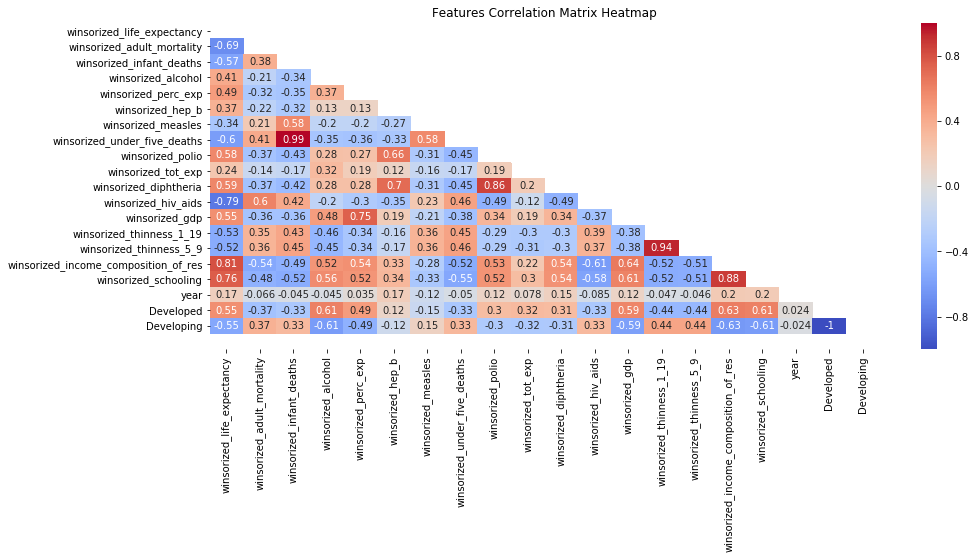

In [113]:
def feat_heatmap():
    mask = np.triu(feature_df.corr())
    plt.figure(figsize=(15,6))
    sns.heatmap(feature_df.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
    plt.ylim(len(feature_df.columns), 0)
    plt.title('Features Correlation Matrix Heatmap')
    plt.show()
feat_heatmap()

### Time for some PCA!

First, lets drop categorical variable.

In [114]:
# let's drop categorical and low correlating variables
pca_df = feature_df.drop(columns=['Developing', 'year', 'country','winsorized_infant_deaths', 'winsorized_polio', 'winsorized_measles', 'winsorized_alcohol', 'winsorized_hep_b', 'winsorized_thinness_5_9','winsorized_tot_exp'])

In [115]:
pca_df.head()

,winsorized_life_expectancy,winsorized_adult_mortality,winsorized_perc_exp,winsorized_under_five_deaths,winsorized_diphtheria,winsorized_hiv_aids,winsorized_gdp,winsorized_thinness_1_19,winsorized_income_composition_of_res,winsorized_schooling,Developed
0,65,263.00,71.28,66.00,65.00,0.10,584.26,14.60,0.48,10.10,0
1,59,271.00,73.52,66.00,62.00,0.10,612.70,14.60,0.48,10.00,0
2,59,268.00,73.22,66.00,64.00,0.10,631.74,14.60,0.47,9.90,0
3,59,272.00,78.18,66.00,67.00,0.10,669.96,14.60,0.46,9.80,0
4,59,275.00,7.10,66.00,68.00,0.10,63.54,14.60,0.45,9.50,0


In [116]:
X = scale(pca_df)
sklearn_pca = PCA()
Y = sklearn_pca.fit_transform(X)
print('Explained variance by Principal Components:', sklearn_pca.explained_variance_ratio_)
print('Eigenvalues:', sklearn_pca.explained_variance_)

Explained variance by Principal Components: [0.55519608 0.10908871 0.06657678 0.06252037 0.05468502 0.04176406
 0.03796509 0.02947454 0.02144067 0.01207574 0.00921294]
Eigenvalues: [6.10924338 1.20038574 0.73259483 0.68795898 0.60174073 0.45956162
 0.41775866 0.32433072 0.23592798 0.13287854 0.10137692]


In [117]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X = StandardScaler().fit_transform(pca_df)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[ 1.00034165 -0.68884709  0.48972352 -0.60502325  0.58849811 -0.79501913
   0.55123658 -0.52563964  0.80852002  0.75839233  0.55115953]
 [-0.68884709  1.00034165 -0.32195058  0.41021997 -0.36847897  0.60302745
  -0.36480832  0.35331077 -0.53938857 -0.4850933  -0.37127414]
 [ 0.48972352 -0.32195058  1.00034165 -0.36129895  0.2766976  -0.30050102
   0.74690846 -0.33714358  0.54343539  0.51910589  0.48605829]
 [-0.60502325  0.41021997 -0.36129895  1.00034165 -0.44635443  0.45748698
  -0.37882629  0.4490718  -0.52207121 -0.54987113 -0.33392618]
 [ 0.58849811 -0.36847897  0.2766976  -0.44635443  1.00034165 -0.48622706
   0.34481178 -0.30323975  0.54185011  0.53742011  0.30632297]
 [-0.79501913  0.60302745 -0.30050102  0.45748698 -0.48622706  1.00034165
  -0.3698777   0.38732977 -0.61336482 -0.57598154 -0.32638271]
 [ 0.55123658 -0.36480832  0.74690846 -0.37882629  0.34481178 -0.3698777
   1.00034165 -0.37824926  0.64085326  0.60628827  0.59247963]
 [-0.52563964  0.35331

In [118]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[ 0.36915251 -0.27328345  0.26496537 -0.27167228  0.25660641 -0.29664083
  0.2964089  -0.25547977  0.36483466  0.35508891  0.28083247]
Eigenvalue 1: 6.109243383166472
----------------------------------------
Eigenvector 2: 
[-0.20681249  0.29836931  0.5009733   0.18432354 -0.28434456  0.39962251
  0.46792112 -0.00937041  0.03675745  0.04140264  0.34727753]
Eigenvalue 2: 1.2003857418675565
----------------------------------------
Eigenvector 3: 
[ 0.57616856  0.06104237 -0.0499884   0.09890783 -0.04193884  0.21721822
  0.0739056   0.01496441 -0.64239981  0.42612316 -0.05599063]
Eigenvalue 3: 0.10137691861793312
----------------------------------------
Eigenvector 4: 
[ 0.65775108  0.14848822 -0.06447158  0.03060787 -0.05512407  0.32793845
  0.00918788  0.02098226  0.39072905 -0.52073003 -0.07270097]
Eigenvalue 4: 0.13287854431043059
----------------------------------------
Eigenvector 5: 
[ 0.1025157  -0.330925    0.23735741  0.36617572  0.06928934 -0.24496902
  0.211917

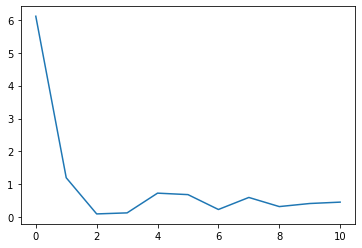

[6.10924338 1.20038574 0.10137692 0.13287854 0.73259483 0.68795898
 0.23592798 0.60174073 0.32433072 0.41775866 0.45956162]


In [119]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.55519608 0.10908871 0.06657678 0.06252037 0.05468502]


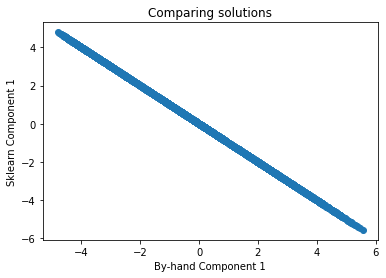

In [120]:
sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

### Summary

There were 22 variables in the original dataset, which was able to be pared down to 11. 
On a high level, it appears HIV, thinness, youth, and adult deaths have negative relationships to life expectancy. 
Conversely, countries with high resources going towards health and education seem to have longer life spans (on average).
This can be explained by whether a country is developed or developing. 

Beyond the intuitive nature of these observations, it's important to analyze the data and review the statistics to prevent general bias from influencing conclusions that may impact the study.

After the data was cleaned, and nulls and outliers were removed, it was possible to use basic statistical methods to determine feature importance and correlation values in reference to our dependant variable (life expectancy).

As you can see from the correlation plot below, there are several variables that are seemingly not directly tied with each other that can help predict controls of life expectancy. In the next stages of modeling, it would be wise to make sure all data is normalized or standardized because most machine learning models assume normality. 

The PCA/feature selection process is a great way to make sure the variables going in to the model don't create issues (like over fitting), and to prevent slow run time by having too many variables to begin with.

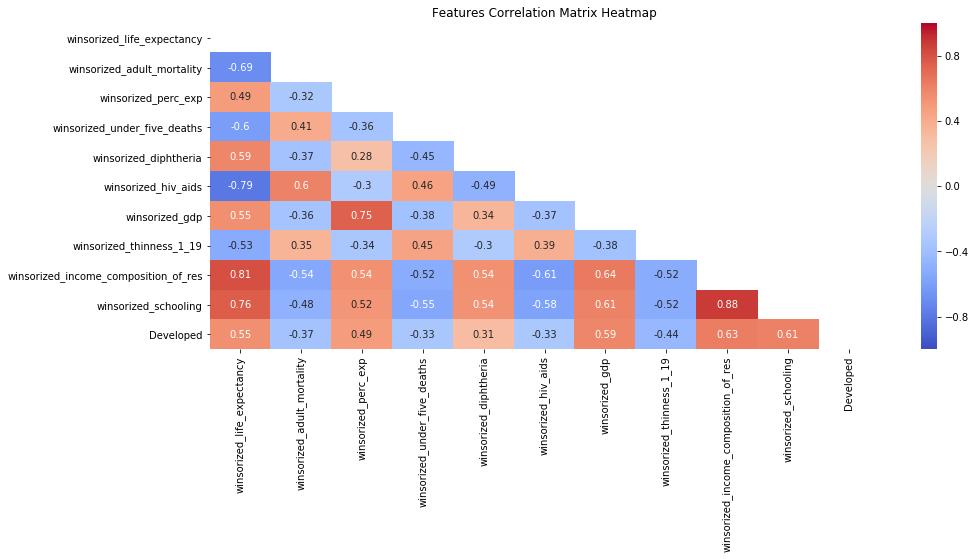

In [121]:
def feat_heatmap():
    mask = np.triu(pca_df.corr())
    plt.figure(figsize=(15,6))
    sns.heatmap(pca_df.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
    plt.ylim(len(pca_df.columns), 0)
    plt.title('Features Correlation Matrix Heatmap')
    plt.show()
feat_heatmap()